## 0. 기본적인 데이터 준비 단계
### 0-1 준비 및 데이터 설정

In [497]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [592]:
df = pd.read_csv('train.csv', encoding='ISO-8859-1')

### 0-2 is_converted 칼럼 정리

In [593]:
#1. is_converted가 NA인 데이터 drop
original_rows = len(df)
df = df.dropna(subset=['is_converted'])
erased_rows = original_rows - len(df)
print('지워진 행: '+str(erased_rows))

지워진 행: 0


In [594]:
print('is_converted unique values:')
df.is_converted.unique()

is_converted unique values:


array([ True, False])

In [595]:
# is_converted 의 값들 정리
# 모두 TRUE or FALSE로 통일, 이외값을 가진 행은 제거
df['is_converted'] = df['is_converted'].astype(str).str.upper()
df = df[df['is_converted'].isin(['TRUE', 'FALSE'])]
print('지워진 행: '+ str(original_rows-erased_rows-len(df)))

지워진 행: 0


### 0-3 중복 행 처리

In [596]:
df.drop_duplicates(keep='first', inplace=True)
len(df)

55780

### 0-4 Class Imbalance Analysis

In [597]:
print(df.is_converted.value_counts())
ratio = df.is_converted.value_counts()[0] / df.is_converted.value_counts()[1]
1-1/ratio

is_converted
FALSE    51160
TRUE      4620
Name: count, dtype: int64


0.9096950742767788

## 1. 100% 차있는 column 처리

In [598]:
for col in df.columns:
    if df[col].isnull().sum() == 0:
        print(col)

bant_submit
business_unit
customer_idx
enterprise
lead_desc_length
customer_position
response_corporate
ver_cus
ver_pro
lead_owner
is_converted


### 1-1 bant_submit -> no encoding needed

In [599]:
df.bant_submit.unique()
# no problem with this numerical data

array([1.  , 0.75, 0.5 , 0.25, 0.  ])

### 1-2 business_unit -> One Hot Encoding

In [600]:
df.business_unit.unique()
# no problem, encoding needed

array(['AS', 'ID', 'IT', 'Solution', 'CM'], dtype=object)

### 1-3 customer_idx -> already numerical

In [601]:
print(len(df.customer_idx.unique()))
value_counts = df.customer_idx.value_counts()
print(value_counts[value_counts > 50])

35112
customer_idx
47466    6853
25096    2404
37680     326
21321     154
18030     122
33350      97
33763      88
25309      86
32240      83
37654      75
31864      68
37657      67
19804      64
29370      60
40344      56
Name: count, dtype: int64


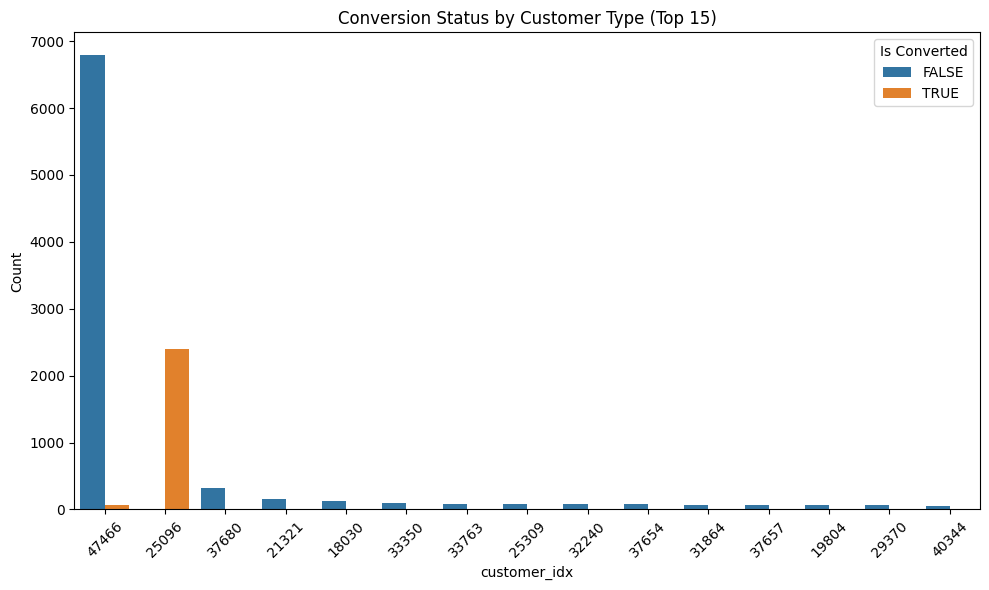

In [602]:
#compare the values of two columns by printing the columns
df.business_subarea.value_counts()

top_5_customer_types = df['customer_idx'].value_counts().nlargest(15).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['customer_idx'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='customer_idx', hue='is_converted', 
              order=df_top_5_customer_types['customer_idx'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('customer_idx')
plt.ylabel('Count')
plt.title('Conversion Status by Customer Type (Top 15)')
plt.legend(title='Is Converted', loc='upper right')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

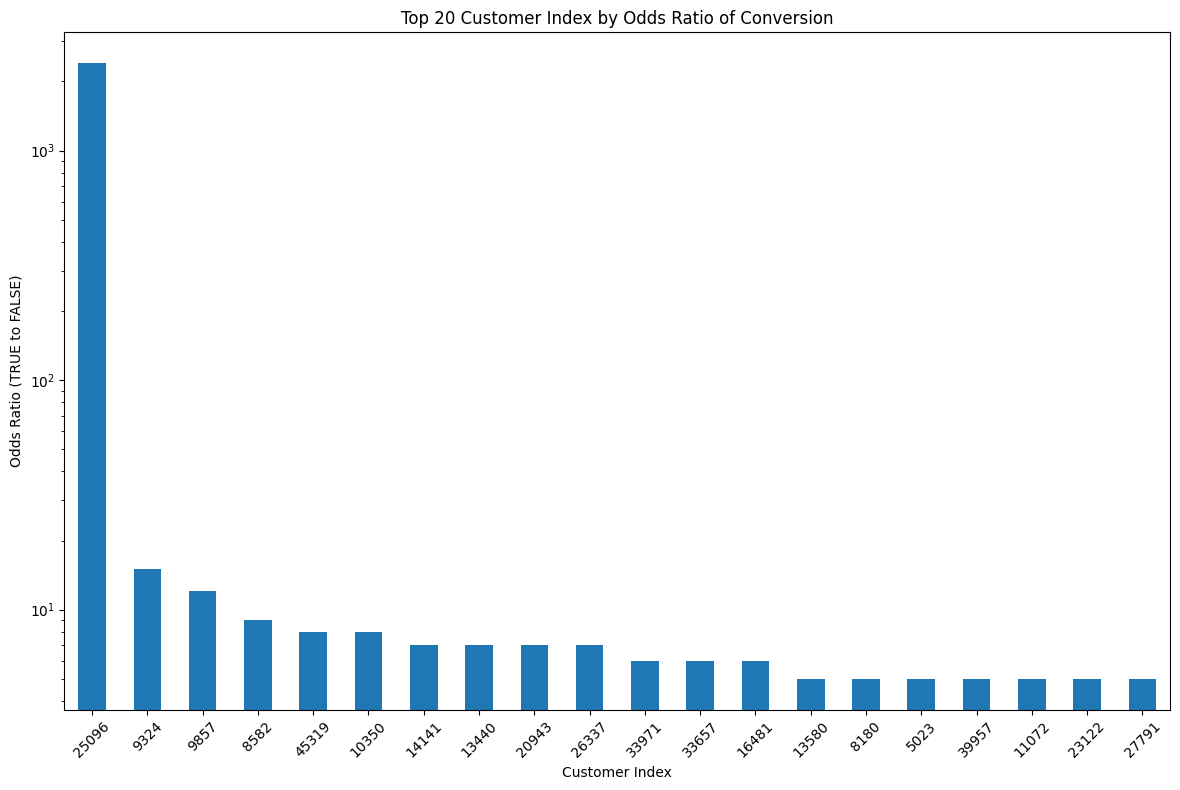

In [603]:
# Function to calculate odds ratio
def calculate_odds_ratio(df):
    # Count the number of True and False is_converted for each customer_idx
    counts = df.groupby('customer_idx')['is_converted'].value_counts().unstack(fill_value=0)
    # Calculate odds = (True+1) / (False+1) to avoid division by zero
    odds_ratio = (counts['TRUE'] + 1) / (counts['FALSE'] + 1)
    return odds_ratio.sort_values(ascending=False)

# Assuming df is your DataFrame

# Calculate odds ratios for each customer_idx
odds_ratios = calculate_odds_ratio(df)

# Select the top N odds ratios for visualization, e.g., top 20
top_n = 20
top_odds_ratios = odds_ratios.head(top_n)

# Create a bar plot for the top N odds ratios
plt.figure(figsize=(12, 8))
top_odds_ratios.plot(kind='bar')
plt.xlabel('Customer Index')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title(f'Top {top_n} Customer Index by Odds Ratio of Conversion')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping

plt.yscale('log')  # Use a logarithmic scale for better readability

plt.show()

In [604]:
## how are we gonna encode this thing though. 

### 1-4 enterprise -> One Hot Encoding

In [605]:
print(len(df.enterprise.unique()))
value_counts = df.enterprise.value_counts()
value_counts
# print(value_counts[value_counts > 50])

# just need categorical encoding

2


enterprise
Enterprise    35638
SMB           20142
Name: count, dtype: int64

### 1-5 lead_desc_length -> already numerical

In [606]:
print(len(df.lead_desc_length.unique()))
value_counts = df.lead_desc_length.value_counts()
print(value_counts[value_counts > 500])
# good ol numerical data. good to go.

909
lead_desc_length
3     9594
14    2782
2      873
10     849
4      799
5      747
1      714
11     674
23     660
18     615
7      610
35     564
17     559
15     551
12     550
9      546
8      512
Name: count, dtype: int64


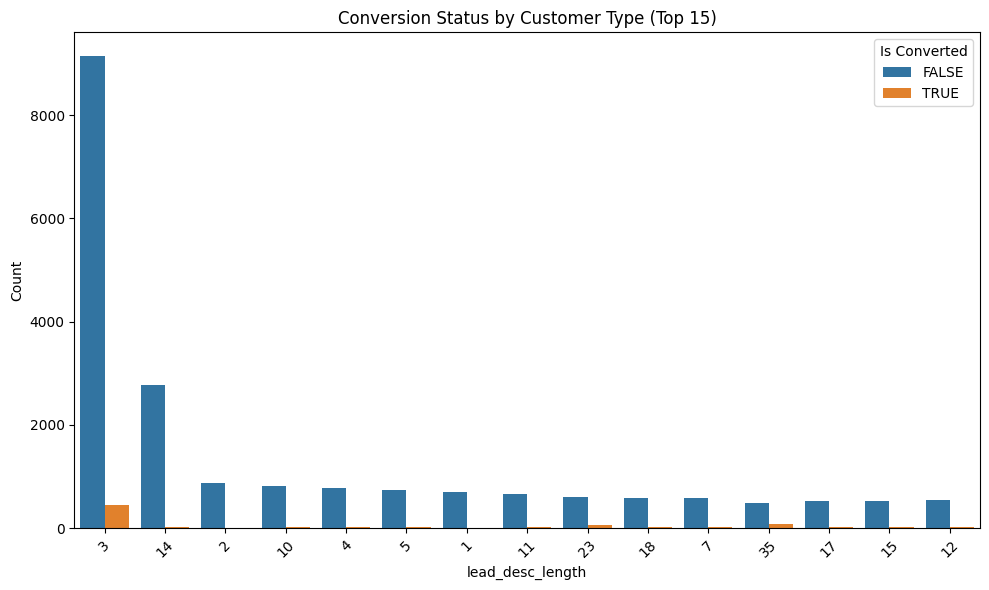

In [607]:


top_5_customer_types = df['lead_desc_length'].value_counts().nlargest(15).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['lead_desc_length'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='lead_desc_length', hue='is_converted', 
              order=df_top_5_customer_types['lead_desc_length'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('lead_desc_length')
plt.ylabel('Count')
plt.title('Conversion Status by Customer Type (Top 15)')
plt.legend(title='Is Converted', loc='upper right')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

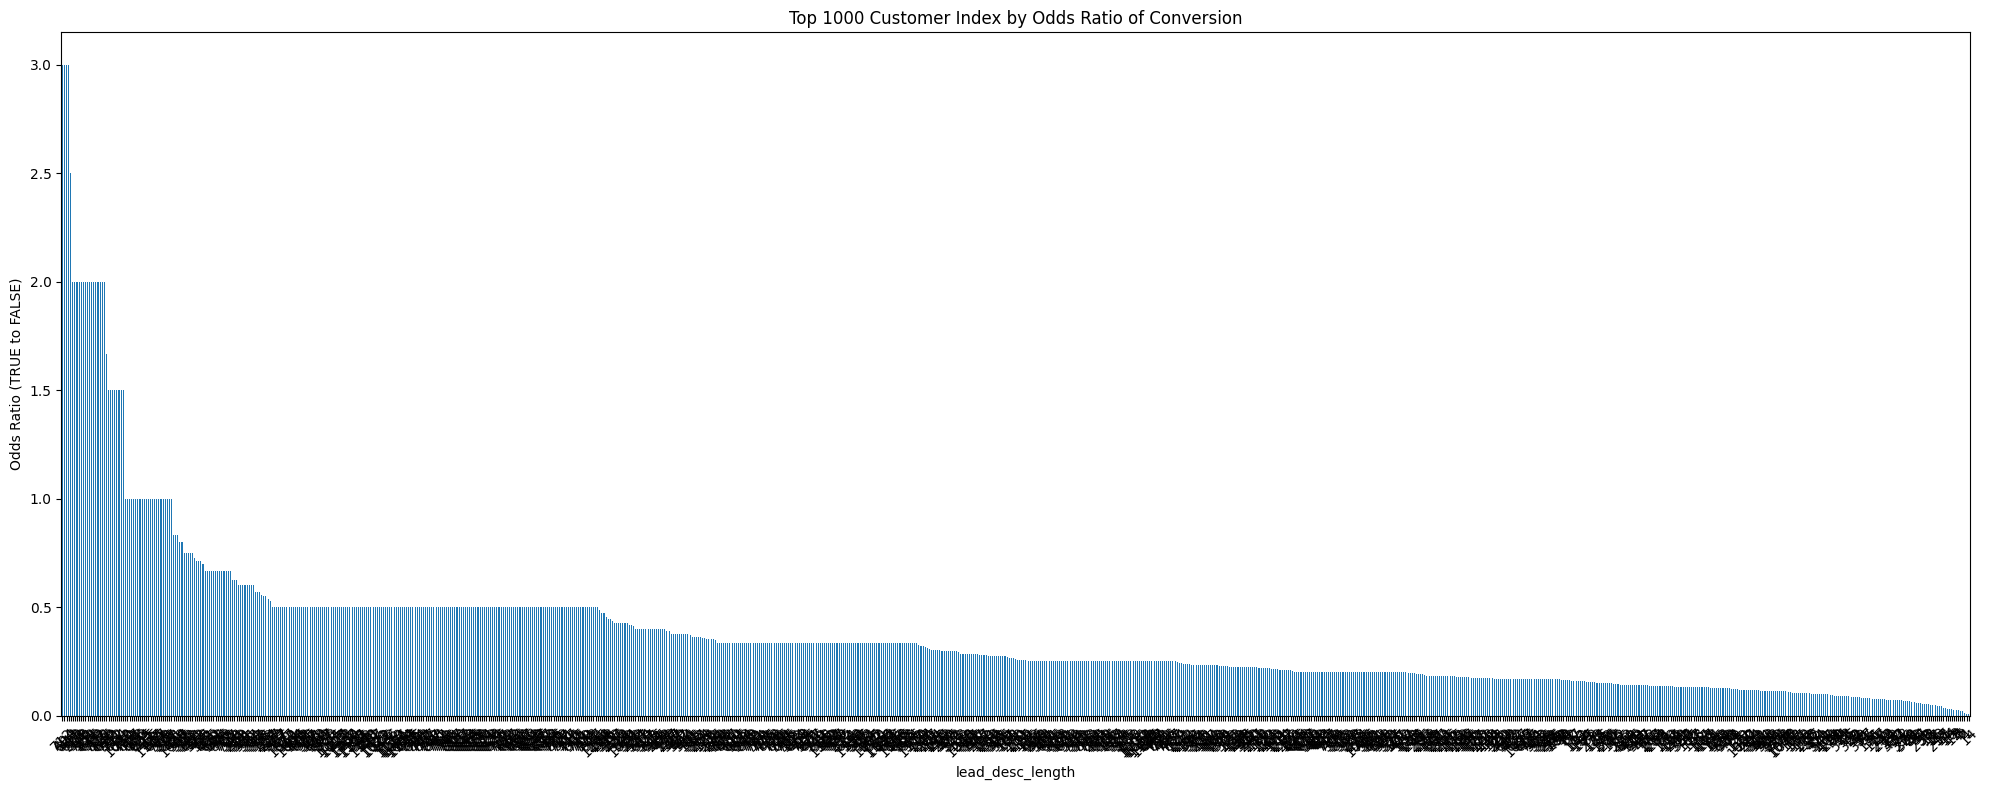

In [608]:
# Function to calculate odds ratio
def calculate_odds_ratio(df):
    # Count the number of True and False is_converted for each customer_idx
    counts = df.groupby('lead_desc_length')['is_converted'].value_counts().unstack(fill_value=0)
    # Calculate odds = (True+1) / (False+1) to avoid division by zero
    odds_ratio = (counts['TRUE'] + 1) / (counts['FALSE'] + 1)
    return odds_ratio.sort_values(ascending=False)

# Assuming df is your DataFrame

# Calculate odds ratios for each customer_idx
odds_ratios = calculate_odds_ratio(df)

# Select the top N odds ratios for visualization, e.g., top 20
top_n = 1000
top_odds_ratios = odds_ratios.head(top_n)

# Create a bar plot for the top N odds ratios
plt.figure(figsize=(20, 8))
top_odds_ratios.plot(kind='bar')
plt.xlabel('lead_desc_length')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title(f'Top {top_n} Customer Index by Odds Ratio of Conversion')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping

# plt.yscale('log')  # Use a logarithmic scale for better readability

plt.show()

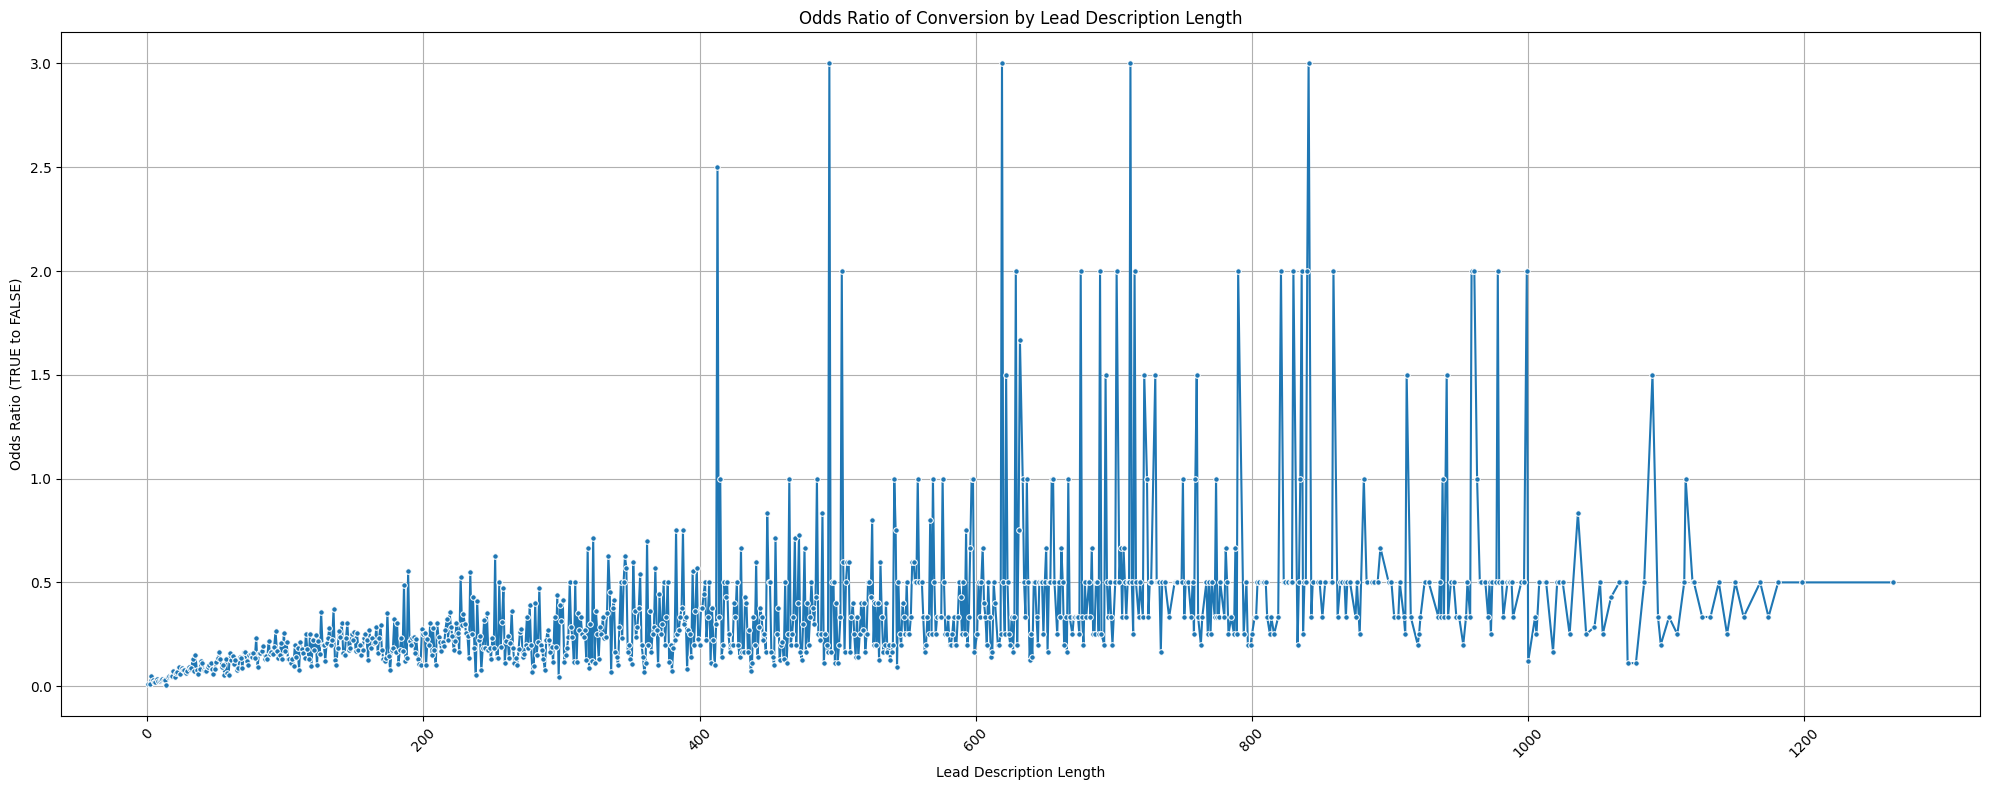

In [609]:
top_n = 10000
top_odds_ratios = odds_ratios.head(top_n)

# Convert the Series to a DataFrame for easier plotting
odds_ratio_df = top_odds_ratios.reset_index()
odds_ratio_df.columns = ['lead_desc_length', 'Odds Ratio']

# Cast 'lead_desc_length' to int for proper ordering in the plot
odds_ratio_df['lead_desc_length'] = odds_ratio_df['lead_desc_length'].astype(int)

# Sort the DataFrame by 'lead_desc_length' to ensure the plot follows the numeric order
odds_ratio_df = odds_ratio_df.sort_values('lead_desc_length')

# Now, create a line plot
plt.figure(figsize=(20, 8))
sns.lineplot(data=odds_ratio_df, x='lead_desc_length', y='Odds Ratio', marker='o', markersize=4)

plt.xlabel('Lead Description Length')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title(f'Odds Ratio of Conversion by Lead Description Length')
plt.xticks(rotation=45)  # Adjust rotation if needed
plt.grid(True)  # Adds grid for better readability
plt.tight_layout()

plt.show()

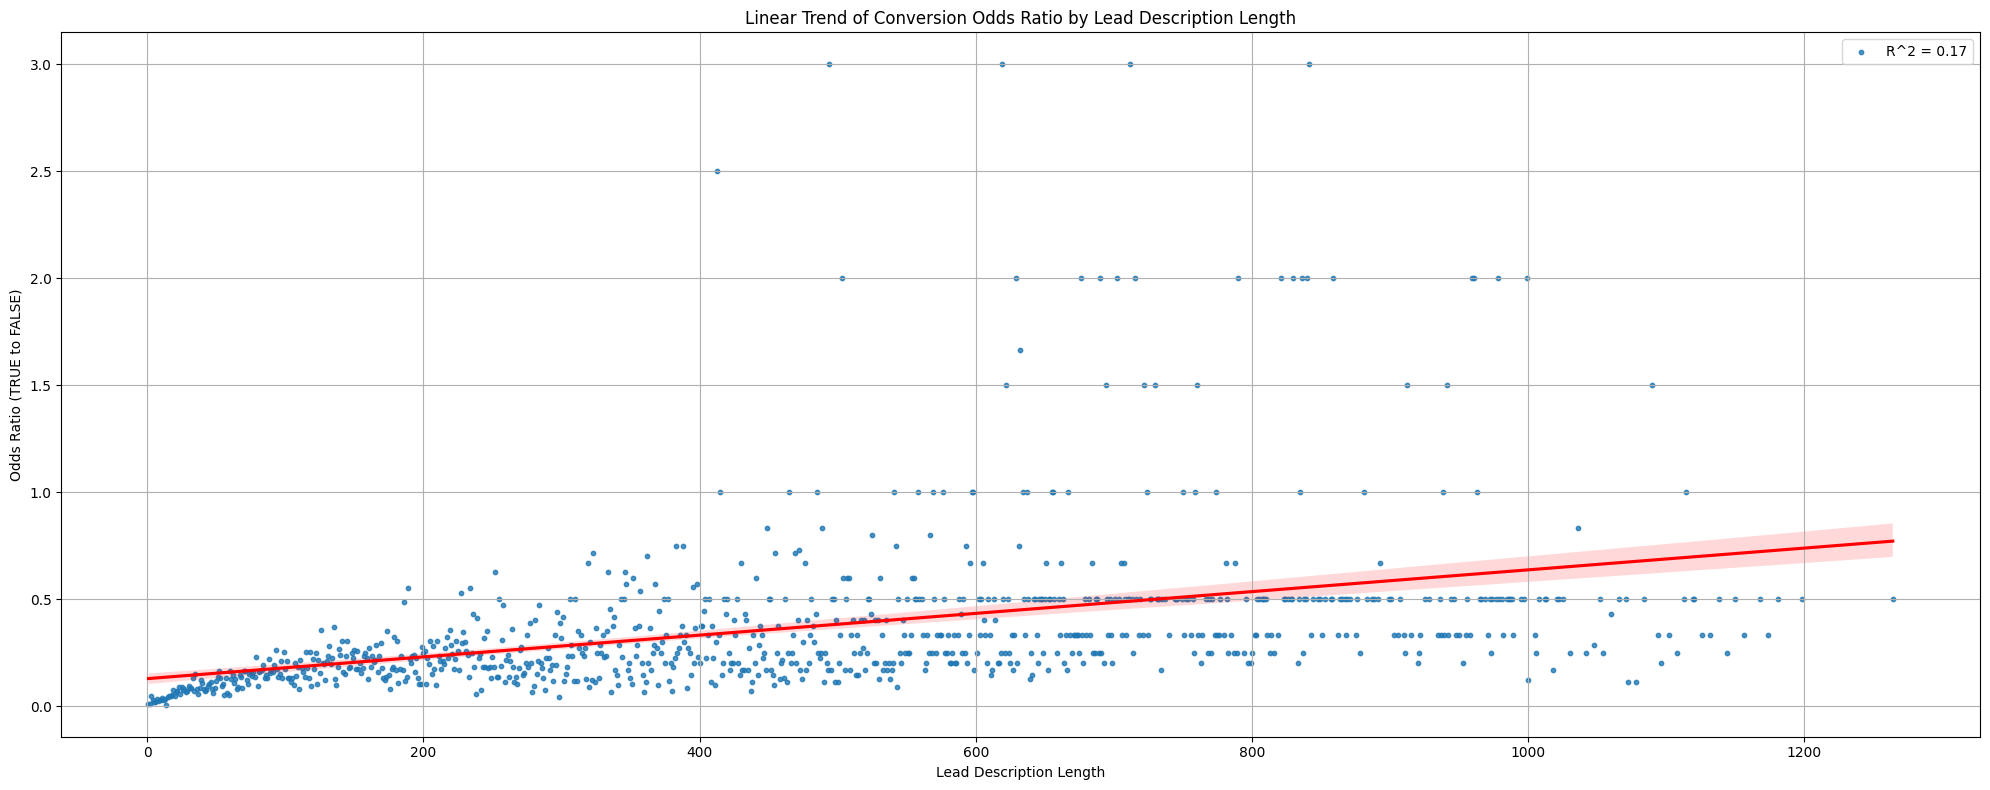

In [610]:
from scipy import stats

odds_ratio_df = odds_ratio_df.dropna(subset=['lead_desc_length', 'Odds Ratio'])

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(odds_ratio_df['lead_desc_length'], odds_ratio_df['Odds Ratio'])

# Calculate R-squared
r_squared = r_value**2

# Use seaborn's regplot to plot the data points and fit a linear regression line
plt.figure(figsize=(20, 8))
sns.regplot(data=odds_ratio_df, x='lead_desc_length', y='Odds Ratio', 
            scatter_kws={'s': 10}, line_kws={'color': 'red'})

# Adding R-squared value as legend
plt.legend([f'R^2 = {r_squared:.2f}'])

plt.xlabel('Lead Description Length')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Linear Trend of Conversion Odds Ratio by Lead Description Length')
plt.grid(True)  # Adds grid for better readability
plt.tight_layout()

plt.show()

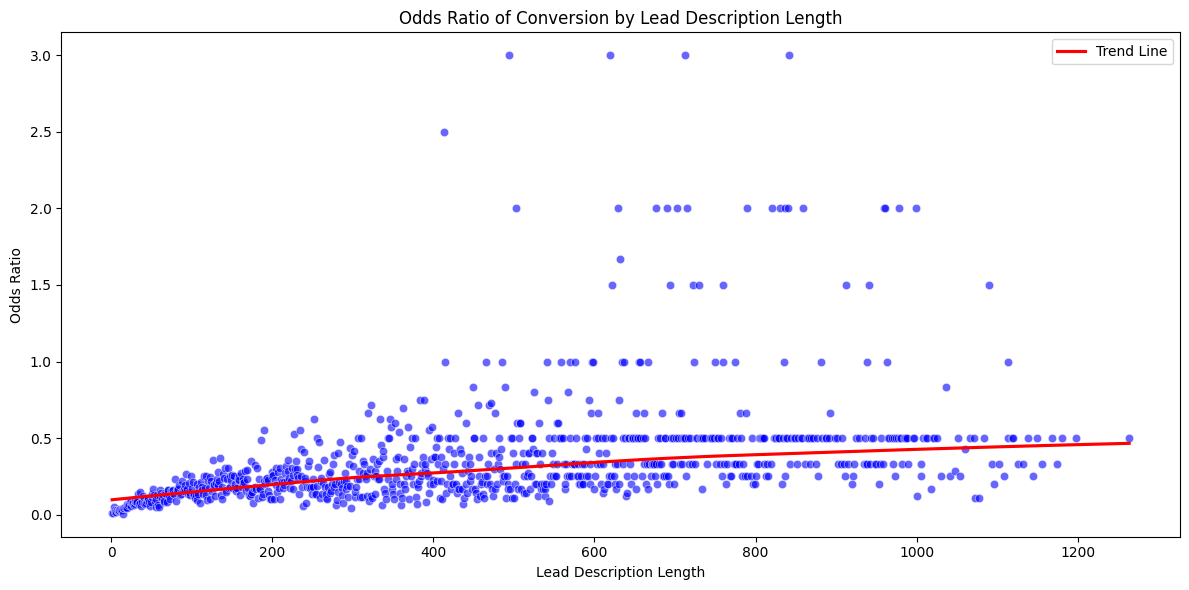

In [611]:
# Make sure 'lead_desc_length' and 'Odds Ratio' are numerical and sorted
odds_ratio_df = odds_ratio_df.dropna(subset=['lead_desc_length', 'Odds Ratio'])
odds_ratio_df['lead_desc_length'] = odds_ratio_df['lead_desc_length'].astype(int)
odds_ratio_df.sort_values('lead_desc_length', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot for individual odds ratios
sns.scatterplot(data=odds_ratio_df, x='lead_desc_length', y='Odds Ratio', color='blue', alpha=0.6)

# Optional: Add a lowess line to show the trend
sns.regplot(data=odds_ratio_df, x='lead_desc_length', y='Odds Ratio', lowess=True, 
            scatter=False, color='red', label='Trend Line')

plt.xlabel('Lead Description Length')
plt.ylabel('Odds Ratio')
plt.title('Odds Ratio of Conversion by Lead Description Length')
plt.legend()

plt.tight_layout()
plt.show()

In [612]:
df.rename(columns=lambda x: x.strip(), inplace=True)

# Reclassify 'lead_desc_length' values to the nearest 50
df['lead_desc_length'] = np.round(df['lead_desc_length'] / 50) * 50

# Display the first few rows to verify the changes
print(df[['lead_desc_length']].head())

   lead_desc_length
0              50.0
1             100.0
2              50.0
3              50.0
4             100.0


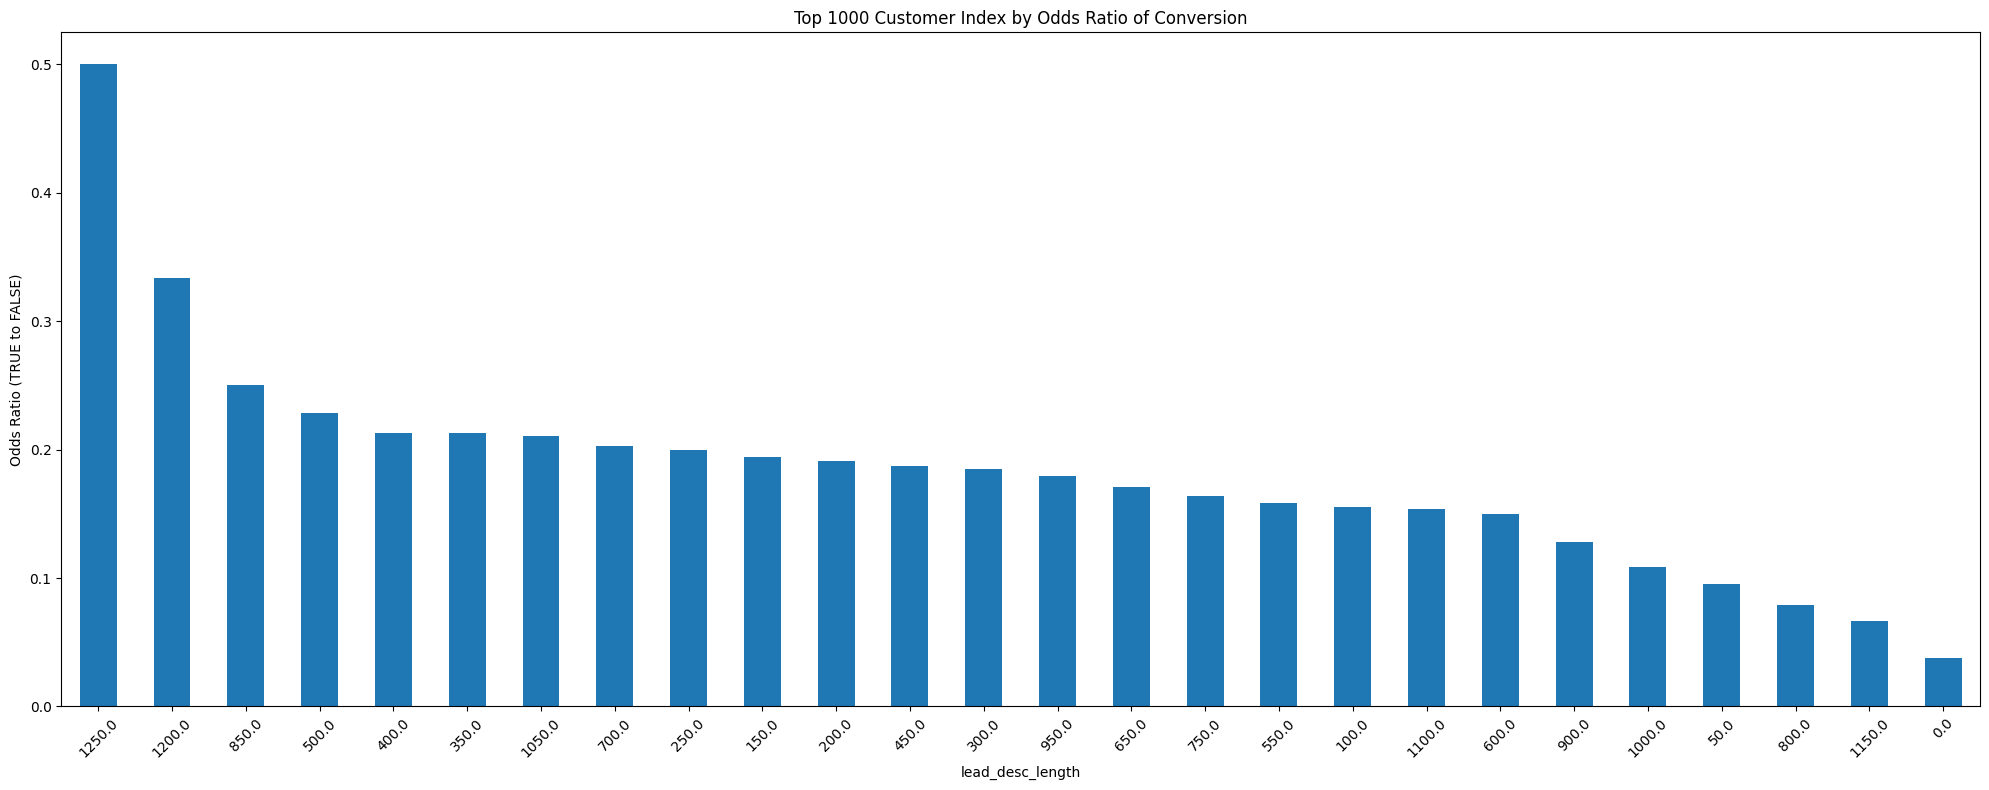

In [613]:
# Function to calculate odds ratio
def calculate_odds_ratio(df):
    # Count the number of True and False is_converted for each customer_idx
    counts = df.groupby('lead_desc_length')['is_converted'].value_counts().unstack(fill_value=0)
    # Calculate odds = (True+1) / (False+1) to avoid division by zero
    odds_ratio = (counts['TRUE'] + 1) / (counts['FALSE'] + 1)
    return odds_ratio.sort_values(ascending=False)

# Assuming df is your DataFrame

# Calculate odds ratios for each customer_idx
odds_ratios = calculate_odds_ratio(df)

# Select the top N odds ratios for visualization, e.g., top 20
top_n = 1000
top_odds_ratios = odds_ratios.head(top_n)

# Create a bar plot for the top N odds ratios
plt.figure(figsize=(20, 8))
top_odds_ratios.plot(kind='bar')
plt.xlabel('lead_desc_length')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title(f'Top {top_n} Customer Index by Odds Ratio of Conversion')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping

# plt.yscale('log')  # Use a logarithmic scale for better readability

plt.show()

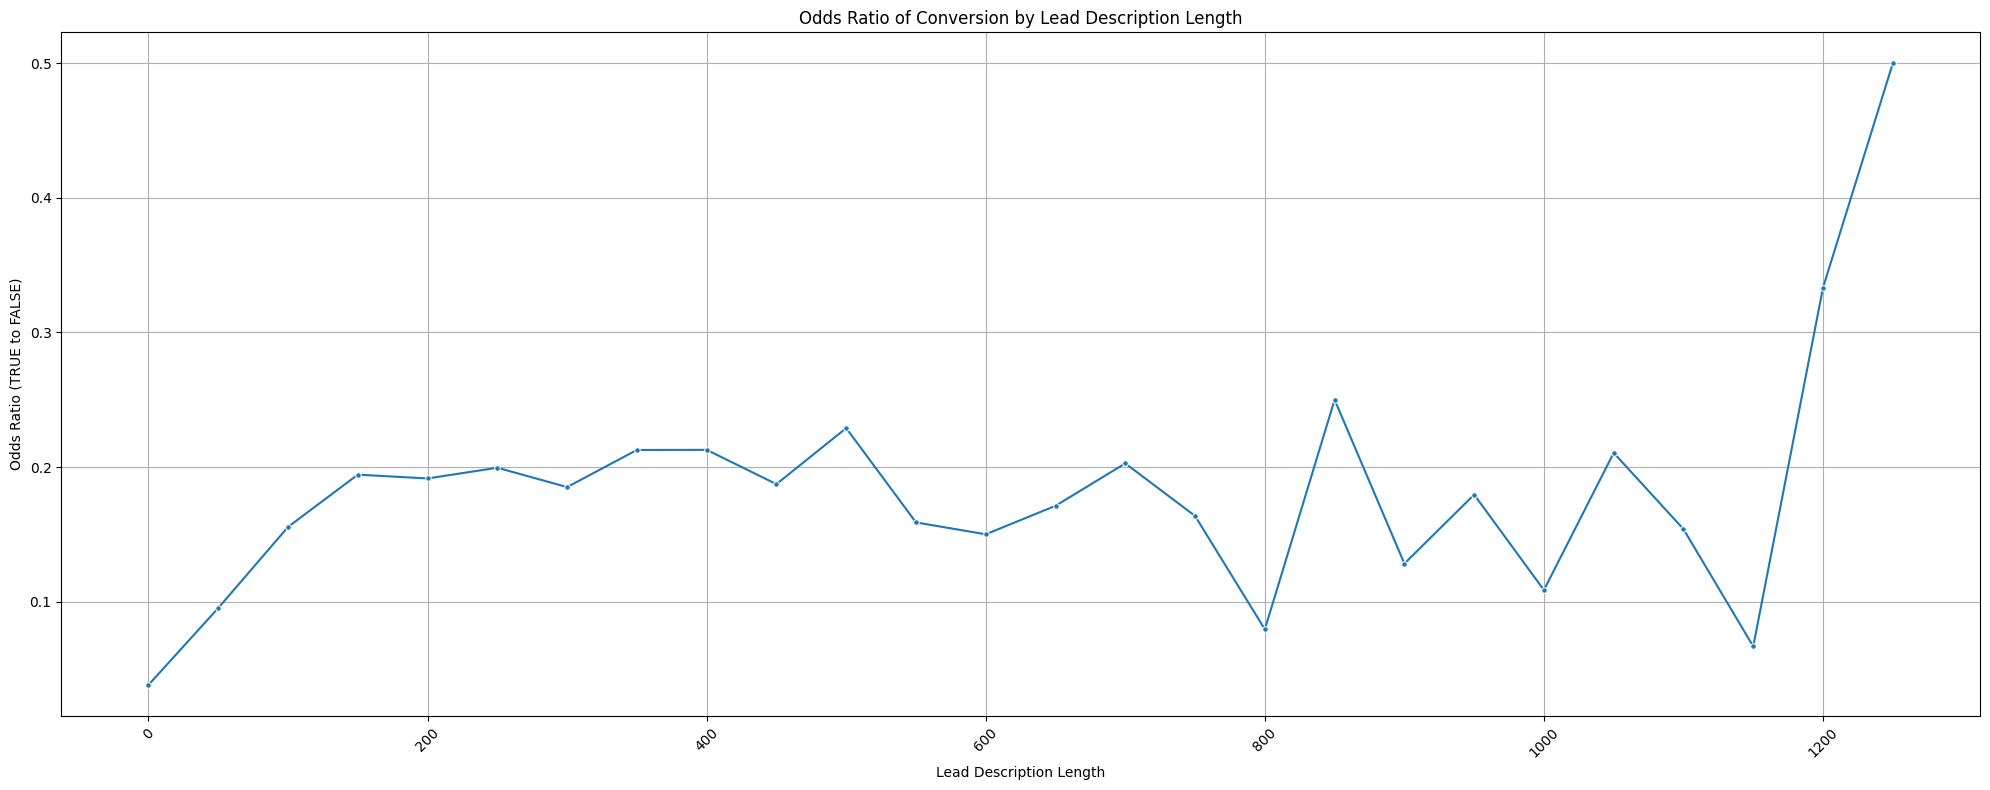

In [614]:
top_n = 100
top_odds_ratios = odds_ratios.head(top_n)

# Convert the Series to a DataFrame for easier plotting
odds_ratio_df = top_odds_ratios.reset_index()
odds_ratio_df.columns = ['lead_desc_length', 'Odds Ratio']

# Cast 'lead_desc_length' to int for proper ordering in the plot
odds_ratio_df['lead_desc_length'] = odds_ratio_df['lead_desc_length'].astype(int)

# Sort the DataFrame by 'lead_desc_length' to ensure the plot follows the numeric order
odds_ratio_df = odds_ratio_df.sort_values('lead_desc_length')

# Now, create a line plot
plt.figure(figsize=(20, 8))
sns.lineplot(data=odds_ratio_df, x='lead_desc_length', y='Odds Ratio', marker='o', markersize=4)

plt.xlabel('Lead Description Length')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title(f'Odds Ratio of Conversion by Lead Description Length')
plt.xticks(rotation=45)  # Adjust rotation if needed
plt.grid(True)  # Adds grid for better readability
plt.tight_layout()

plt.show()

### 1-6 customer_position -> ordinal encoding or stuff

In [615]:
print(len(df.customer_position.unique()))
value_counts = df.customer_position.value_counts()
print(value_counts[value_counts > 0])

117
customer_position
none                      17667
manager                    7905
ceo/founder                7745
other                      6115
director                   4735
                          ...  
principal & director          1
business partner              1
hon dean                      1
chairman                      1
radiology professional        1
Name: count, Length: 117, dtype: int64


In [616]:
# domain knowledge

# Executive or senior management
# Middle management
# First-level management
# Intermediate or experienced (senior staff)
# Entry-level

df['customer_position'] = df['customer_position'].replace({
    'manager': 'first_management_level',
    'ceo/founder':'c_level',
    'executive': 'c_level',
    'director': 'middle_management_level',
    'associate/analyst':'intermediate_level',
    'partner':'c_level',
    'entry level':'entry_level',
    'trainee':'entry_level',
    'c-level executive':'c_level',
    'vice president':'c_level',
    'end-user':'end_user',
    'intern':'entry_level',
    'hospital':'end_user',
    'installer':'entry_level',
    'government':'middle_management_level',
    'cargo':'end_user',
    'software /solution provider':'end_user',
    'manufacturer':'end_user',
    'consultant':'entry_level',
    'system integrator':'intermediate_level',
    'homeowner':'end_user',
    'employee':'entry_level',
    'medical device manufacturer':'end_user',
    'vicepresident':'c_level',
    'others':'other',
    'unpaid':'end_user',
    'engineering':'intermediate_level',
    'decision maker':'c_level',
    'leadership/executive office/owner':'c_level',
    'decision influencer':'middle_management_level',
    'bulgaria':'middle_management_level',
    'assistant professor':'middle_management_level',
    'commercial end-user':'end_user',
    'decision-influencer':'middle_management_level',
    'c-levelexecutive':'c_level',
    'ceo/fundador':'c_level',
    'educator':'first_management_level',
    'decision-maker':'c_level',
    'physics teacher':'middle_management_level',
    'entrylevel':'entry_level',
    'architect/consultant':'intermediate_level',
    'operations':'first_management_level',
    'business development':'first_management_level',
    'founder':'c_level',
    'entrepreneurship':'c_level',
    'administrative':'intermediate_level',
    'customer':'end_user',
    'no influence':'entry_level',
    'not applicable':'other',
    'exhibition':'intermediate_level',
    'medical imaging specialist':'intermediate_level',
    'gerente':'other',
    'consulting':'entry_level',
    'science teacher':'middle_management_level',
    'math and physics teacher':'middle_management_level',
    'other - please specify - cedia association':'other',
    'av management':'first_management_level',
    'associate professor':'middle_management_level',
    'business partner':'c_level',
    'radiology professional':'intermediate_level',
    'english trainer for ielts,toefl,pte,gre,sat exams.':'middle_management_level',
    'quantitative aptitude faculty':'end_user',
    'assistant professor of enlish':'middle_management_level',
    'professor':'c_level',
    'principal & director':'c_level',
    'chairman':'c_level',
    'the big boss':'c_level',
    'associate professor in electronics engg':'middle_management_level',
    'subsidiary sales (ise)':'intermediate_level',
    'cheif executive officer':'c_level',
    'chief executive officer':'c_level',
    'co-founder':'c_level',
    'professional trainer':'first_management_level',
    'senior lecturer':'middle_management_level',
    'asst prof.':'middle_management_level',
    'neet/ olympiad expert faculty':'end_user',
    'education':'middle_management_level',
    'teacher':'middle_management_level',
    'tierarzt':'other',
    'sales':'intermediate_level',
    'president':'c_level',
    'business development/sales':'first_management_level',
    'director cum faculty at gaining apex coaching centre':'middle_management_level',
    'physics and mathematics teacher':'middle_management_level',
    'pgt physics':'middle_management_level',
    'research':'intermediate_level',
    'professor of mathematics':'middle_management_level',
    'hon dean':'c_level',
    'education professional':'end_user',
    'chemistry teacher':'middle_management_level',
    'academic coordinator/ post graduate teacher (accountancy, business studies)/ tgt (ict)':'first_management_level',
    'genel mÃ¼dÃ¼r':'c_level',
    'tÃ©cnico':'other',
    'academic specialist':'first_management_level',
    'surgery professional':'first_management_level',
    'principal at oxford integrated pu science college':'c_level',
    'maths lecturer':'first_management_level',
    'this is a consume display requirement for home purpose.':'end_user',
    'exhibitiontv':'intermediate_level',
    'pathologist':'middle_management_level',
    'physics faculty':'middle_management_level',
    'mindenes':'intermediate_level',
    'proprietÃ¡rio(a)':'other',
    'prof.':'middle_management_level',
    'teacher/middle school coordinator':'middle_management_level',
    'market intelligence/research':'intermediate_level',
    'product management':'first_management_level',
    'career coach':'first_management_level',
    'distributor':'c_level',
    'guest faculty':'intermediate_level',
    'vp':'c_level',
    'business unit director':'first_management_level',
    'architecture/consult':'intermediate_level',
    'technical':'intermediate_level',
    'commercial consultant':'intermediate_level',
    'lider de desarrollo':'first_management_level',
    'fÅorvos':'middle_management_level'
})

In [617]:
df.customer_position.isna().sum()

0

### 1-7 response_corporate -> mean-target encoding / KFold target encoding

In [618]:
print(len(df.response_corporate.unique()))
value_counts = df.response_corporate.value_counts()
print(value_counts[value_counts > 0])

53
response_corporate
LGEIL    16684
LGESP     8808
LGEUS     5136
LGEPH     2542
LGEMS     2531
LGEGF     2020
LGECB     2011
LGEUK     1634
LGECL     1255
LGEPS     1222
LGESJ     1139
LGEPR     1002
LGEDG      938
LGEIS      846
LGEPL      777
LGEEG      627
LGEES      578
LGETK      535
LGEVH      524
LGEAR      489
LGEKR      426
LGEHK      369
LGESL      343
LGEAP      340
LGEMK      319
LGEFS      293
LGEAF      283
LGEIN      279
LGESA      259
LGELF      256
LGECI      254
LGETH      181
LGEEF      157
LGEPT      109
LGEML      108
LGEBN       95
LGEYK       75
LGEHS       51
LGETT       46
LGECH       43
LGEJP       39
LGEAS       32
LGESW       30
LGEMC       28
LGERO       26
LGEEB       13
LGEAG        8
LGERA        8
LGECZ        7
LGELA        2
LGEUR        1
LGEIR        1
LGEBT        1
Name: count, dtype: int64


### 1-8 ver_cus -> no encoding needed

In [619]:
print(len(df.ver_cus.unique()))
value_counts = df.ver_cus.value_counts()
print(value_counts[value_counts > 0])

2
ver_cus
0    53400
1     2380
Name: count, dtype: int64


### 1-9 ver_pro -> no encoding

In [620]:
print(len(df.ver_pro.unique()))
value_counts = df.ver_pro.value_counts()
print(value_counts[value_counts > 0])

2
ver_pro
0    52847
1     2933
Name: count, dtype: int64


### 1-10 lead_owner -> numerical. no encoding

In [621]:
print(len(df.lead_owner.unique()))
value_counts = df.lead_owner.value_counts()
print(value_counts[value_counts > 0])

984
lead_owner
174     4563
175     4090
23      2281
97      2275
194     2029
        ... 
974        1
160        1
486        1
909        1
1114       1
Name: count, Length: 984, dtype: int64


## 2 칼럼별 처리 (NA율 > 90%)

### 2-1 id_strategic_ver, it_strategic_ver, idit_strategic_ver -> no encoding

In [622]:
dropped_columns = []
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 90:
        print(col)

id_strategic_ver
it_strategic_ver
idit_strategic_ver
business_subarea


In [623]:
# idit_strategic_ver 으로 다 되기 때문에 id_strategic_ver, it_strategic_ver 제거

df.drop(columns='id_strategic_ver', inplace=True, axis=1)
df.drop(columns='it_strategic_ver', inplace=True, axis=1)
df.idit_strategic_ver.fillna(0, inplace=True)

print(df.idit_strategic_ver.unique())
print(df.idit_strategic_ver.isna().sum())
df.columns

[0. 1.]
0


Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'idit_strategic_ver', 'customer_job',
       'lead_desc_length', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_country.1',
       'customer_position', 'response_corporate', 'expected_timeline',
       'ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_ratio_per_bu',
       'business_area', 'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

### 2-2 business_subarea -> dropped

In [624]:
df.business_subarea.fillna('NA', inplace=True)
print('na values in business_subarea: '+str(df['business_subarea'].isna().sum()))
print('number of unique values in business_subarea: '+str(len(df['business_subarea'].unique())))
print(df['business_subarea'].value_counts())

print(df['business_subarea'].unique())

na values in business_subarea: 0
number of unique values in business_subarea: 87
business_subarea
NA                               50600
Others                            1585
Other Stores                       270
Hospital                           245
Manufacturing Factory / Plant      190
                                 ...  
Duty Free Shop                       2
Dormitory                            1
Casino Resort                        1
Holdings                             1
Travel Agency                        1
Name: count, Length: 87, dtype: int64
['Engineering' 'Advertising' 'Construction' 'IT/Software' 'NA'
 'Manufacturing' 'Energy' 'Developer/Property' 'Entertainment'
 'Agriculture' 'Pharmaceutical' 'Others' 'Banking' 'Consulting'
 'Healthcare' 'Finance' 'Broadcasting & Media' 'Distribution Center'
 'Law Firm' 'Logistics' 'Telecommunication' 'Aerospace' 'Network/Cabling'
 'Insurance' 'Institute & Academy' 'Hotel' 'K12 Kindergarten & Schools'
 'Hospital' 'Mixed-use (Multi 

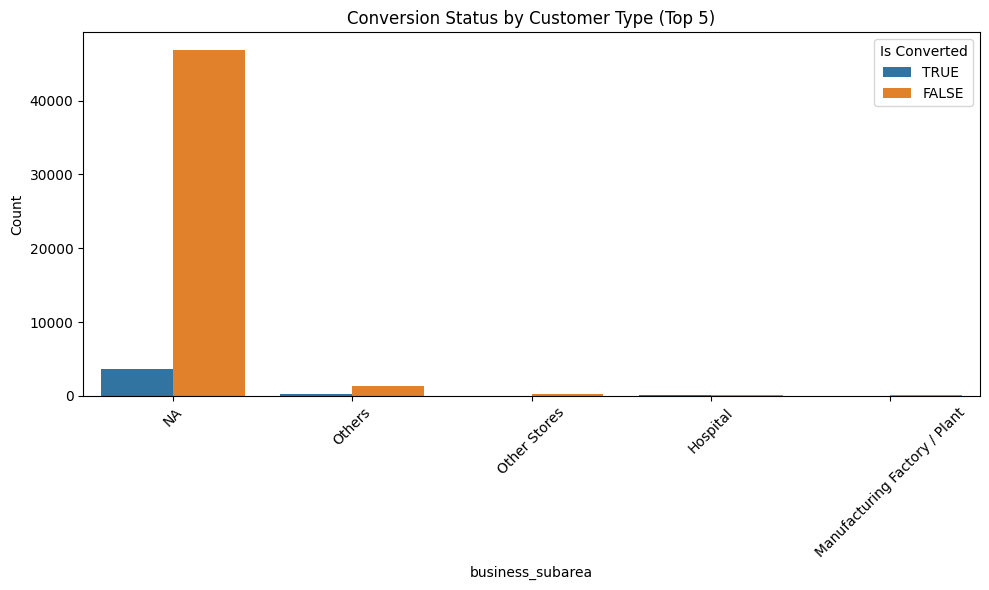

In [625]:
#compare the values of two columns by printing the columns
df.business_subarea.value_counts()

top_5_customer_types = df['business_subarea'].value_counts().nlargest(5).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['business_subarea'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='business_subarea', hue='is_converted', 
              order=df_top_5_customer_types['business_subarea'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('business_subarea')
plt.ylabel('Count')
plt.title('Conversion Status by Customer Type (Top 5)')
plt.legend(title='Is Converted', loc='upper right')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

In [626]:
df.drop(columns='business_subarea', inplace=True, axis=1)
len(df.columns)
df.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'idit_strategic_ver', 'customer_job',
       'lead_desc_length', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_country.1',
       'customer_position', 'response_corporate', 'expected_timeline',
       'ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_ratio_per_bu',
       'business_area', 'lead_owner', 'is_converted'],
      dtype='object')

## 3 칼럼별 처리 (NA율 > 50%)

In [627]:
#칼럼별 NA율이 50% 이상인 칼럼 나열
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 50:
        print(col, df[col].isnull().sum()/len(df)*100)
        #df.drop(col, axis=1, inplace=True)

com_reg_ver_win_rate 74.69702402294729
customer_type 74.14485478666188
historical_existing_cnt 77.82359268555038
product_subcategory 83.85442811043384
product_modelname 83.80960917891717
expected_timeline 50.72068841878809
ver_win_rate_x 68.11222660451774
ver_win_ratio_per_bu 73.31660093223378
business_area 68.11222660451774


### 3-1 com_reg_ver_win_rate -> no encoding needed. Imputation needed

Imputation gonna be done later as a whole dataframe using IterativeImputer, a multivariate Imputation. KNN Imputation can be used for a univariate imputation

### 3-2 customer_type -> 

In [628]:
df['customer_type'] = df['customer_type'].fillna('Unknown')
print(len(df.customer_type.unique()))
print(df.customer_type.value_counts())
print(df.customer_type.unique())

34
customer_type
Unknown                         41358
End-Customer                     6552
End Customer                     3546
Specifier/ Influencer            2328
Channel Partner                  1282
Service Partner                   316
Solution Eco-Partner              128
Installer/Contractor               42
Specifier / Influencer             38
Corporate                          28
Engineer                           18
HVAC Engineer                      17
Technician                         16
Consultant                         15
Developer                          14
Other                              10
Software/Solution Provider          7
End-user                            7
Manager / Director                  7
Home Owner                          6
Etc.                                6
Architect/Consultant                5
Homeowner                           5
Installer                           5
Interior Designer                   5
Distributor                      

In [629]:
# Replace the specified 'expected_timeline' values
df['customer_type'] = df['customer_type'].replace({
    'End-Customer': 'End Customer',
    'Specifier/ Influencer': 'Specifier / Influencer',
    'End-user': 'End Customer',
    'Homeowner': 'End Customer',
    'Home Owner' : 'End Customer',
    'Software/Solution Provider' : 'Software / Solution Provider',
    'Installer':'Installer/Contractor',
    'Commercial end-user':'End Customer',
    'Dealer/Distributor':'Distributor'
    
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['customer_type'].value_counts()
print(len(updated_counts))
print(updated_counts)

25
customer_type
Unknown                         41358
End Customer                    10117
Specifier / Influencer           2366
Channel Partner                  1282
Service Partner                   316
Solution Eco-Partner              128
Installer/Contractor               47
Corporate                          28
Engineer                           18
HVAC Engineer                      17
Technician                         16
Consultant                         15
Developer                          14
Other                              10
Software / Solution Provider        8
Manager / Director                  7
Distributor                         6
Etc.                                6
Interior Designer                   5
Architect/Consultant                5
Others                              4
Reseller                            4
Technical Assistant                 1
System Integrator                   1
Administrator                       1
Name: count, dtype: int64


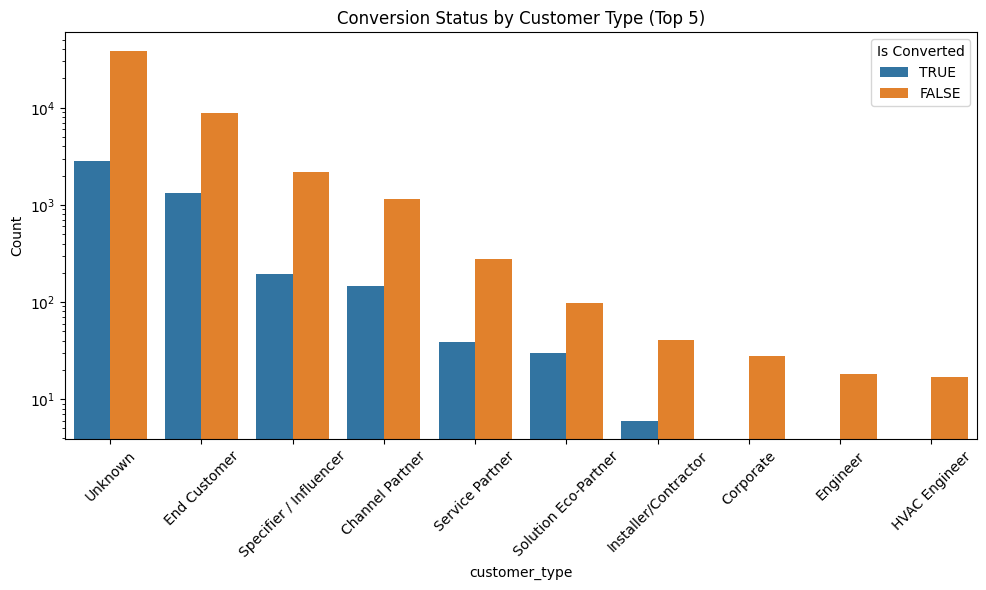

In [630]:
#compare the values of two columns by printing the columns
df.customer_type.value_counts()

top_5_customer_types = df['customer_type'].value_counts().nlargest(10).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['customer_type'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='customer_type', hue='is_converted', 
              order=df_top_5_customer_types['customer_type'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('customer_type')
plt.ylabel('Count')
plt.title('Conversion Status by Customer Type (Top 5)')
plt.legend(title='Is Converted', loc='upper right')

plt.yscale('log')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

Odds Ratio for NA values in 'customer_type': 0.0


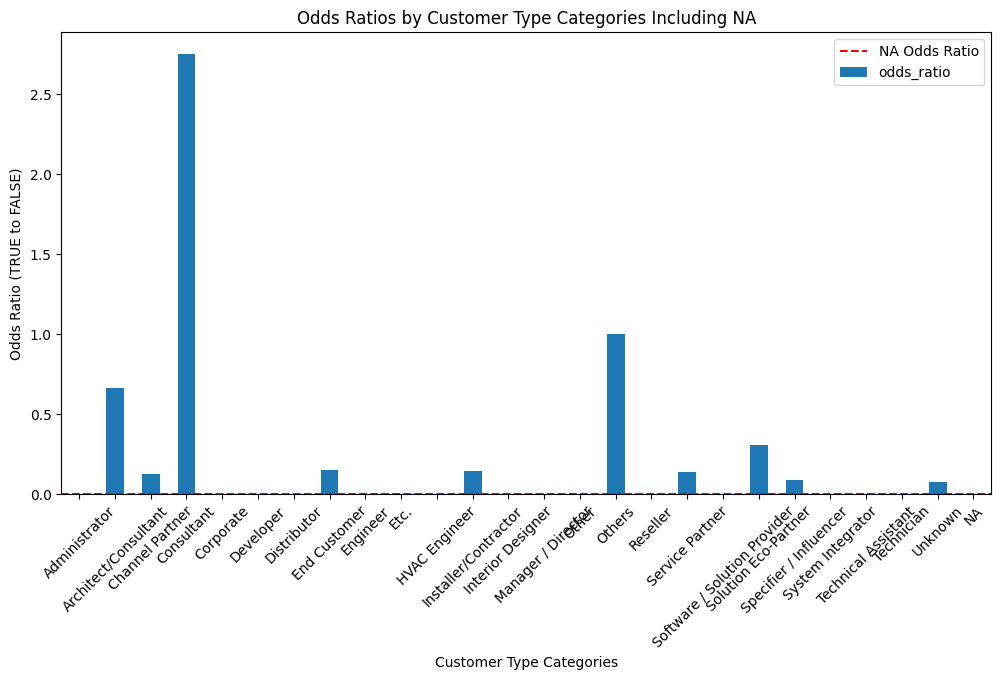

In [631]:
# Separate groups
na_group = df[df['customer_type'].isna()]
non_na_group = df[~df['customer_type'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'customer_type': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('customer_type')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('Customer Type Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by Customer Type Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [632]:
# df.drop(columns='customer_type', inplace=True, axis=1)

### 3-3 historical_existing_cnt -> no encoding needed

In [633]:
#도메인 지식으로는, 이 데이터가 회사에서 온것이므로, 회사가 단 한번이라도 고객을 상대했더라면 그 기록이 남았을것이다. 
# 따라서 이 칼럼의 NA는 전적이 없다, 즉 0으로 채울 수 있다. Domain Knowledge에 의한 imputation

# df = df.drop(columns=['historical_existing_cnt'])

df.historical_existing_cnt.fillna(0, inplace=True)
df.historical_existing_cnt.unique()

array([0.000e+00, 1.200e+01, 1.440e+02, 3.000e+00, 2.300e+01, 4.700e+01,
       1.000e+00, 1.900e+01, 4.200e+01, 7.500e+01, 1.700e+01, 2.000e+01,
       5.000e+00, 2.000e+00, 1.150e+02, 4.000e+00, 1.600e+01, 6.000e+00,
       3.100e+01, 4.900e+01, 1.000e+01, 1.100e+01, 4.000e+01, 7.000e+00,
       6.100e+01, 4.500e+01, 5.700e+01, 1.750e+02, 1.300e+01, 9.900e+01,
       1.500e+01, 8.000e+00, 2.100e+01, 5.600e+01, 6.660e+02, 1.220e+02,
       3.240e+02, 2.200e+01, 8.000e+01, 3.600e+01, 2.800e+01, 1.720e+02,
       6.600e+01, 3.200e+01, 5.300e+01, 3.800e+01, 1.890e+02, 5.800e+01,
       2.700e+01, 1.060e+02, 1.680e+02, 9.000e+00, 4.600e+01, 4.800e+01,
       5.200e+01, 7.300e+01, 9.200e+01, 6.000e+01, 3.900e+01, 1.800e+01,
       1.400e+01, 2.120e+02, 4.720e+02, 3.900e+02, 6.900e+01, 2.330e+02,
       2.900e+01, 3.000e+01, 2.400e+01, 7.800e+01, 1.070e+02, 4.100e+01,
       1.660e+02, 5.900e+01, 4.400e+01, 1.140e+02, 3.700e+01, 3.500e+01,
       1.580e+02, 8.500e+01, 7.700e+01, 2.600e+01, 

Odds Ratio for NA values in 'historical_existing_cnt': 0.0


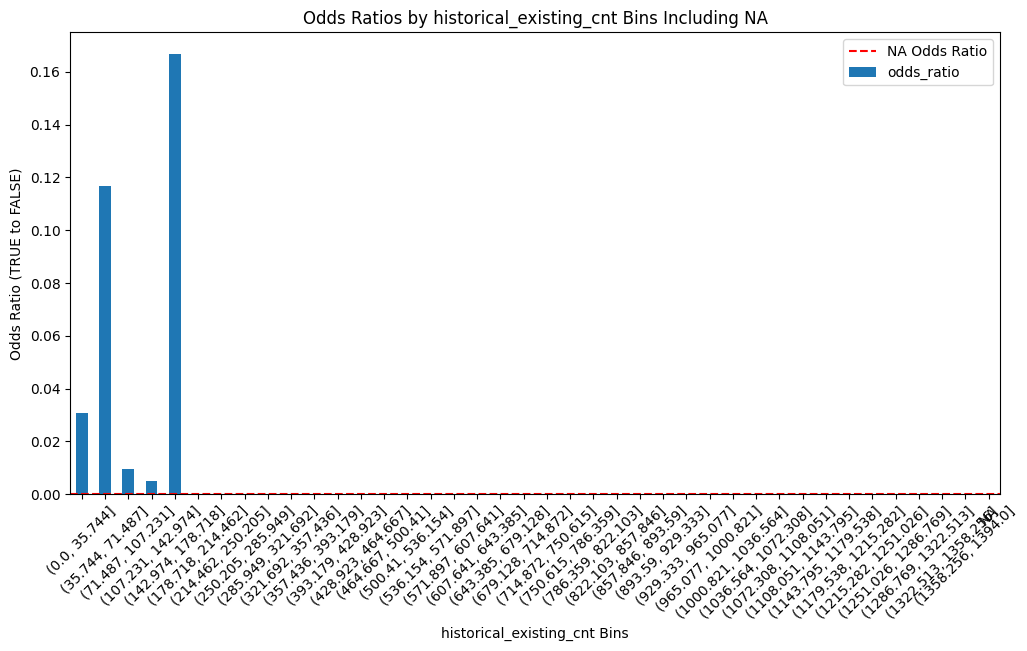

In [634]:
# Separate groups
na_group = df[df['historical_existing_cnt'].isna()]
non_na_group = df[~df['historical_existing_cnt'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'historical_existing_cnt': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['historical_existing_cnt'].min(), non_na_group['historical_existing_cnt'].max(), 40)
non_na_group['binned'] = pd.cut(non_na_group['historical_existing_cnt'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('historical_existing_cnt Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by historical_existing_cnt Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### 3-4 product subcategory -> one-hot encoding

In [635]:
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 50:
        print(col, df[col].isnull().sum()/len(df)*100)

com_reg_ver_win_rate 74.69702402294729
product_subcategory 83.85442811043384
product_modelname 83.80960917891717
expected_timeline 50.72068841878809
ver_win_rate_x 68.11222660451774
ver_win_ratio_per_bu 73.31660093223378
business_area 68.11222660451774


In [636]:
df['product_subcategory'].isna().sum()

46774

In [637]:
# product subcategory를 알아왔다 한다는것 자체만으로도 고객이 상품에 관심이 있다는것을 의미한다. 고로 null 값은 답을 주지 않았다는 것이므로 NA로 채워준다.

# Replace the values in 'product_subcategory' column
df['product_subcategory'] = df['product_subcategory'].apply(lambda x: 'NA' if pd.isnull(x) or x == 'NA' else 'Filled')

# Verify the changes
print(df['product_subcategory'].value_counts())

product_subcategory
NA        46774
Filled     9006
Name: count, dtype: int64


In [638]:
print(len(df['product_subcategory'].unique()))
print(df['product_subcategory'].value_counts())
df['product_subcategory'].unique()

2
product_subcategory
NA        46774
Filled     9006
Name: count, dtype: int64


array(['NA', 'Filled'], dtype=object)

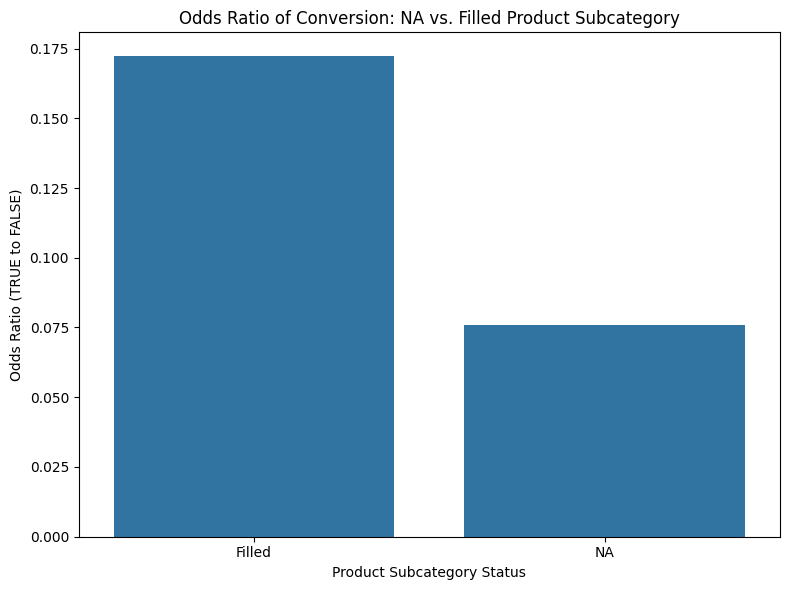

In [639]:
# Assuming df is your DataFrame

# Calculate odds ratio for 'NA' and 'Filled' groups in 'product_subcategory'
odds_ratio = df.groupby('product_subcategory')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
odds_ratio['Odds Ratio'] = odds_ratio['TRUE'] / odds_ratio['FALSE']

# Reset the index to use in seaborn barplot
odds_ratios_subcategory = odds_ratio.reset_index()[['product_subcategory', 'Odds Ratio']]

plt.figure(figsize=(8, 6))
sns.barplot(data=odds_ratios_subcategory, x='product_subcategory', y='Odds Ratio')
plt.xlabel('Product Subcategory Status')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion: NA vs. Filled Product Subcategory')
plt.tight_layout()
plt.show()

### 3-5 product_modelname -> one-hot encoding

In [640]:
# product modelname을 알아왔다 한다는것 자체만으로도 고객이 상품에 관심이 있다는것을 의미한다. 고로 null 값은 답을 주지 않았다는 것이므로 NA로 채워준다.

# Replace the values in 'product_modelname' column
df['product_modelname'] = df['product_modelname'].apply(lambda x: 'NA' if pd.isnull(x) or x == 'NA' else 'Filled')

# Verify the changes
print(df['product_modelname'].value_counts())

product_modelname
NA        46749
Filled     9031
Name: count, dtype: int64


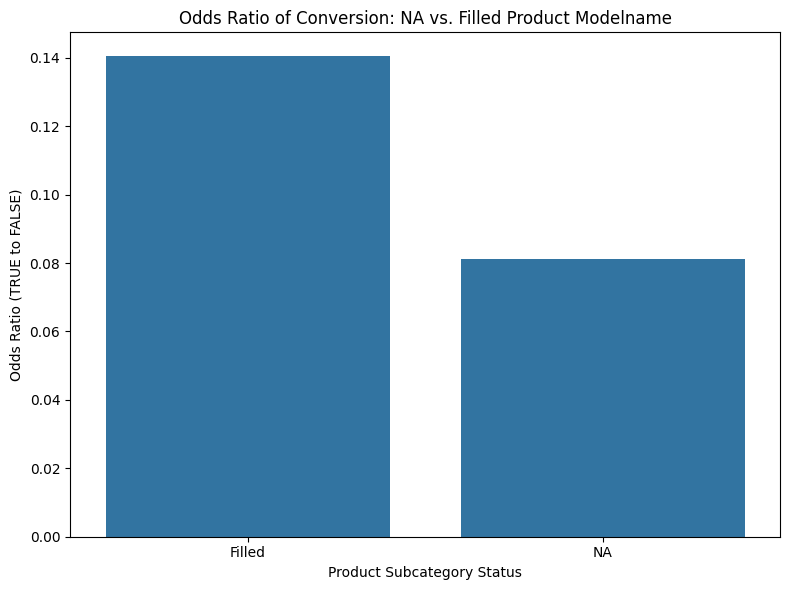

In [641]:
# Calculate odds ratio for 'NA' and 'Filled' groups in 'product_subcategory'
odds_ratio = df.groupby('product_modelname')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
odds_ratio['Odds Ratio'] = odds_ratio['TRUE'] / odds_ratio['FALSE']

# Reset the index to use in seaborn barplot
odds_ratios_subcategory = odds_ratio.reset_index()[['product_modelname', 'Odds Ratio']]

plt.figure(figsize=(8, 6))
sns.barplot(data=odds_ratios_subcategory, x='product_modelname', y='Odds Ratio')
plt.xlabel('Product Subcategory Status')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion: NA vs. Filled Product Modelname')
plt.tight_layout()
plt.show()

### 3-6 expected_timeline -> mean target encoding or ordinal encoding

In [642]:
print(len(df['expected_timeline'].unique()))
print(df['expected_timeline'].value_counts())
df['expected_timeline'].unique()

450
expected_timeline
less than 3 months                                                                                                            16768
3 months ~ 6 months                                                                                                            4798
more than a year                                                                                                               2874
9 months ~ 1 year                                                                                                              1070
6 months ~ 9 months                                                                                                            1043
                                                                                                                              ...  
no requirement of this time                                                                                                       1
not reachable , lead shared with partner              

array(['less than 3 months', nan, '3 months ~ 6 months',
       '9 months ~ 1 year', 'more than a year', '6 months ~ 9 months',
       'quote has been sent to customer.',
       'partner was exploring on eol model for some requiremeent. no designated sales or closure expected hence closing in the system.',
       'already close in july purchse with rd',
       'client not interested in product.. receing call and not answering properly',
       'being followed up', 'being followed up.',
       'repeated inquiry from client. he was just inquiring but have not confimred on purchase. we have tried mulitple times but client is not interested in buying.',
       'update- 7th aug--demo given. customer will confirm next week',
       "tried to reach him multipe times from last 7 days but couldn't get through",
       'details send', 'discused with ankit in dehli',
       'requires detail for tender. no purchase requirement right now.',
       'partner is into static signages. he need to connec

In [549]:
value_counts = df['expected_timeline'].value_counts()

# Filter for unique values with a count of more than 50
filtered_value_counts = value_counts[value_counts > 3]

# Display the filtered unique values and their counts
print(filtered_value_counts)

expected_timeline
less than 3 months     1734
3 months ~ 6 months     426
more than a year        272
9 months ~ 1 year       264
6 months ~ 9 months     167
Name: count, dtype: int64


In [550]:
# Replace the specified 'expected_timeline' values
df['expected_timeline'] = df['expected_timeline'].replace({
    'less_than_3_months': 'less than 3 months',  # merge into 'less than 3 months'
    'being followed up.': 'being followed up',  # merge into 'being followed up.'
    'forwarded to bdo, being followed up':'being followed up',
    'less than 6 months': '3 months ~ 6 months',  # merge into '3 months ~ 6 months'
    '3_months_~_6_months' : '3 months ~ 6 months',
    '9_months_~_1_year':'9 months ~ 1 year',
    '6_months_~_9_months':'6 months ~ 9 months',
    'more_than_a_year':'more than a year',
    'not answering call':'no time information',
    'couldn\'t connect':'no time information',
    'didn\'t respond':'no requirement',
    'budget issue':'no time information',
    'the client is not having any requirement hence closig in system. although the details of idb are mailed to client.':'no requirement',
    'duplicate lead':'no requirement',
    'rnr':'etc.',
    'details send':'being followed up',
    'quote send':'being followed up',
    'details shared':'being followed up',
    'the client is not having any requirement, he was only browsing through the produt hence closig in system. although the details of idb are mailed to client.':'no requirement'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['expected_timeline'].value_counts()
print(updated_counts)

expected_timeline
less than 3 months     1734
3 months ~ 6 months     426
more than a year        272
9 months ~ 1 year       264
6 months ~ 9 months     167
Name: count, dtype: int64


In [551]:
top_expected_timelines = df['expected_timeline'].value_counts().nlargest(9).index

# Replace all other 'expected_timeline' values with 'Others'
df['expected_timeline'] = df['expected_timeline'].apply(lambda x: x if x in top_expected_timelines else 'etc.')


In [552]:
df['expected_timeline'] = df['expected_timeline'].fillna('Unknown')
value_counts = df['expected_timeline'].value_counts()

# Filter for unique values with a count of more than 50
filtered_value_counts = value_counts[value_counts > 3]

# Display the filtered unique values and their counts
print(filtered_value_counts)

expected_timeline
etc.                   2408
less than 3 months     1734
3 months ~ 6 months     426
more than a year        272
9 months ~ 1 year       264
6 months ~ 9 months     167
Name: count, dtype: int64


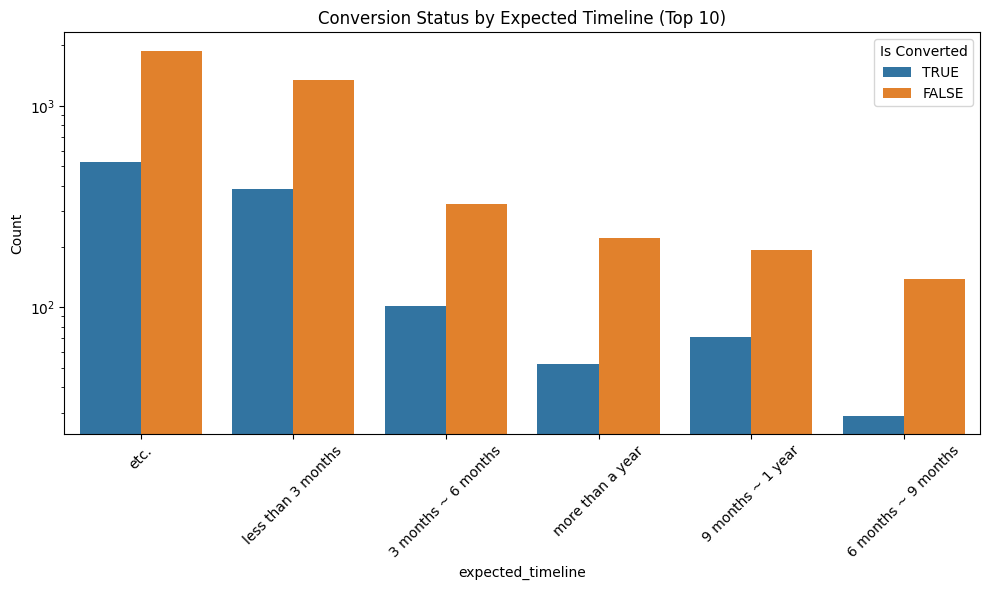

In [553]:
#compare the values of two columns by printing the columns
df.customer_type.value_counts()

top_5_customer_types = df['expected_timeline'].value_counts().nlargest(10).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['expected_timeline'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='expected_timeline', hue='is_converted', 
              order=df_top_5_customer_types['expected_timeline'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('expected_timeline')
plt.ylabel('Count')
plt.title('Conversion Status by Expected Timeline (Top 10)')
plt.legend(title='Is Converted', loc='upper right')

plt.yscale('log')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

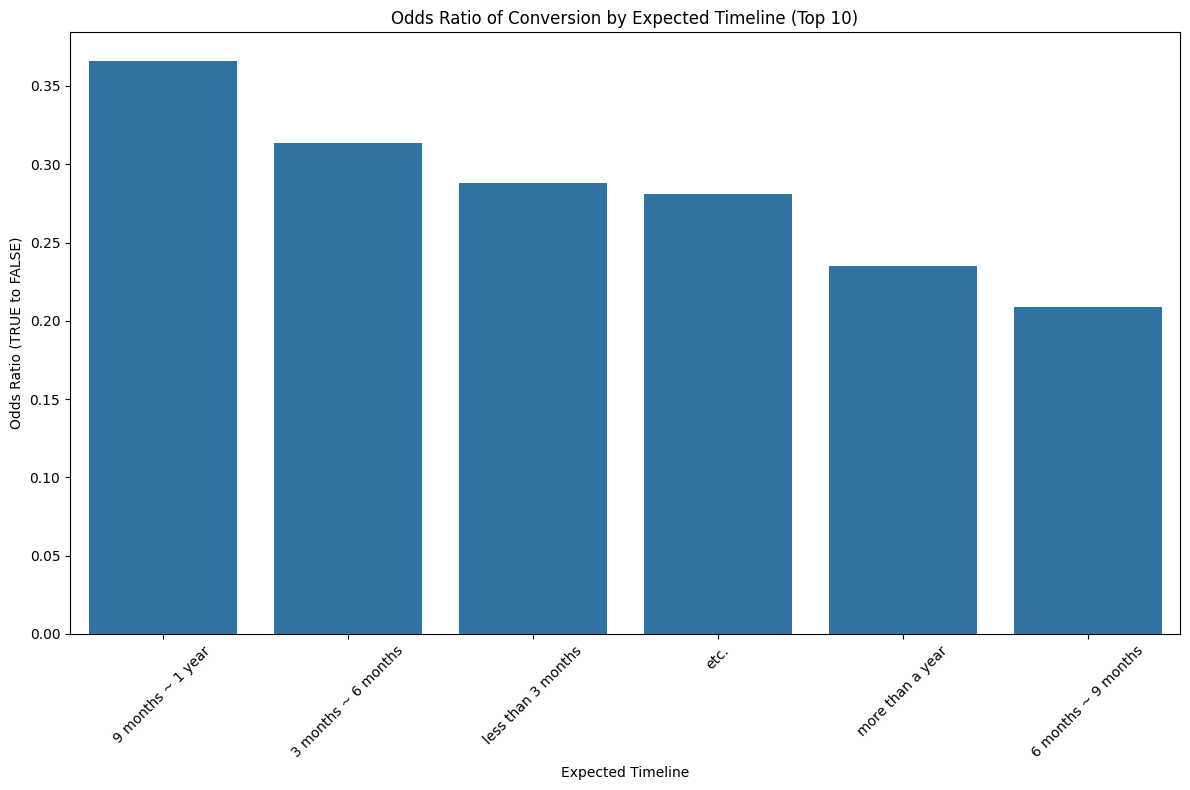

In [554]:
def calculate_odds_ratio(group):
    converted = group[group['is_converted'] == 'TRUE'].shape[0]
    not_converted = group[group['is_converted'] == 'FALSE'].shape[0]
    odds_ratio = (converted / (not_converted + 1))  # Adding 1 to avoid division by zero
    return odds_ratio

odds_ratios = df.groupby('expected_timeline').apply(calculate_odds_ratio)

# Filter to keep only the top 10 'expected_timeline' based on the odds ratio
top_10_odds_ratios = odds_ratios.nlargest(10)

# Create a DataFrame for visualization
odds_ratio_df = pd.DataFrame({'expected_timeline': top_10_odds_ratios.index, 'Odds Ratio': top_10_odds_ratios.values})

plt.figure(figsize=(12, 8))
sns.barplot(data=odds_ratio_df, x='expected_timeline', y='Odds Ratio')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('Expected Timeline')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Expected Timeline (Top 10)')
plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

In [555]:
df.drop(columns='expected_timeline', inplace=True, axis=1)
df.columns

Index(['id', 'bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'idit_strategic_ver', 'customer_job',
       'lead_desc_length', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_country.1',
       'customer_position', 'response_corporate', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area', 'lead_owner',
       'is_converted'],
      dtype='object')

### 3-7 ver_win_rate_x -> Imputed as a whole later

Odds Ratio for NA values in 'ver_win_rate_x': 0.13780918727915195


C:\Users\Jungha Cho\AppData\Local\Temp\ipykernel_2228\1512288660.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)


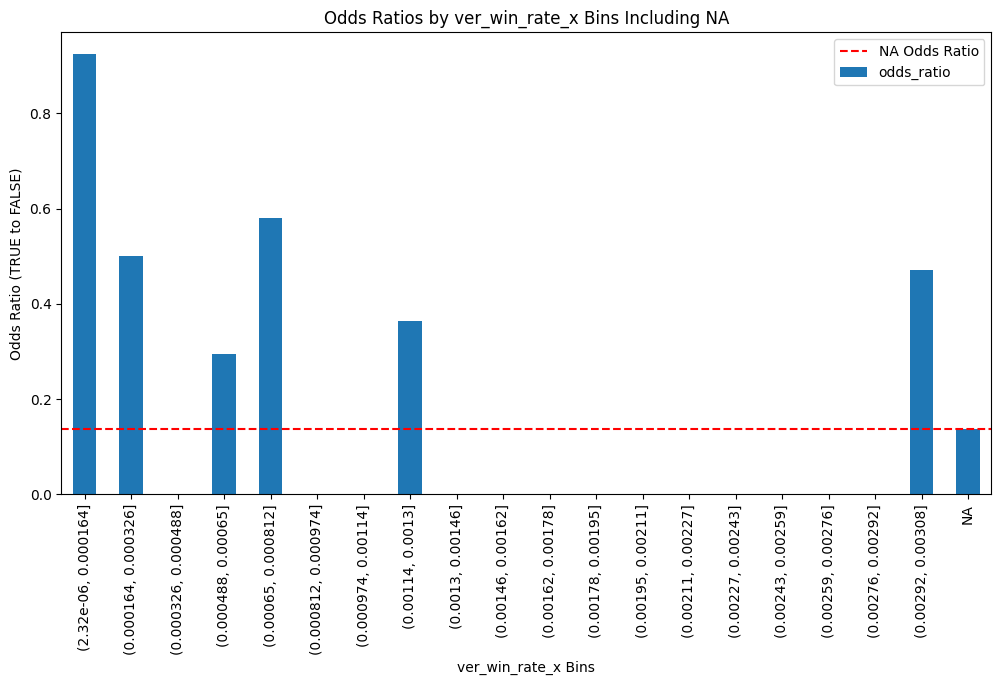

In [556]:
# Separate groups
na_group = df[df['ver_win_rate_x'].isna()]
non_na_group = df[~df['ver_win_rate_x'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'ver_win_rate_x': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['ver_win_rate_x'].min(), non_na_group['ver_win_rate_x'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_rate_x Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_rate_x Bins Including NA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [557]:
# from sklearn.impute import KNNImputer

# # Initialize the KNN Imputer with default parameters (you can choose to modify these)
# imputer = KNNImputer(n_neighbors=5)

# # It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# # Let's first ensure the column is of a numerical type, converting it if necessary
# df['ver_win_rate_x'] = pd.to_numeric(df['ver_win_rate_x'], errors='coerce')

# # Apply the imputer to the DataFrame
# # df_imputed = df.copy()
# # df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
# df['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
# # Check the first few entries of the column to verify imputation
# # df_imputed['ver_win_rate_x'].head()
# df['ver_win_rate_x'].head()

Odds Ratio for NA values in 'ver_win_rate_x': 0.13780918727915195


C:\Users\Jungha Cho\AppData\Local\Temp\ipykernel_2228\1512288660.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)


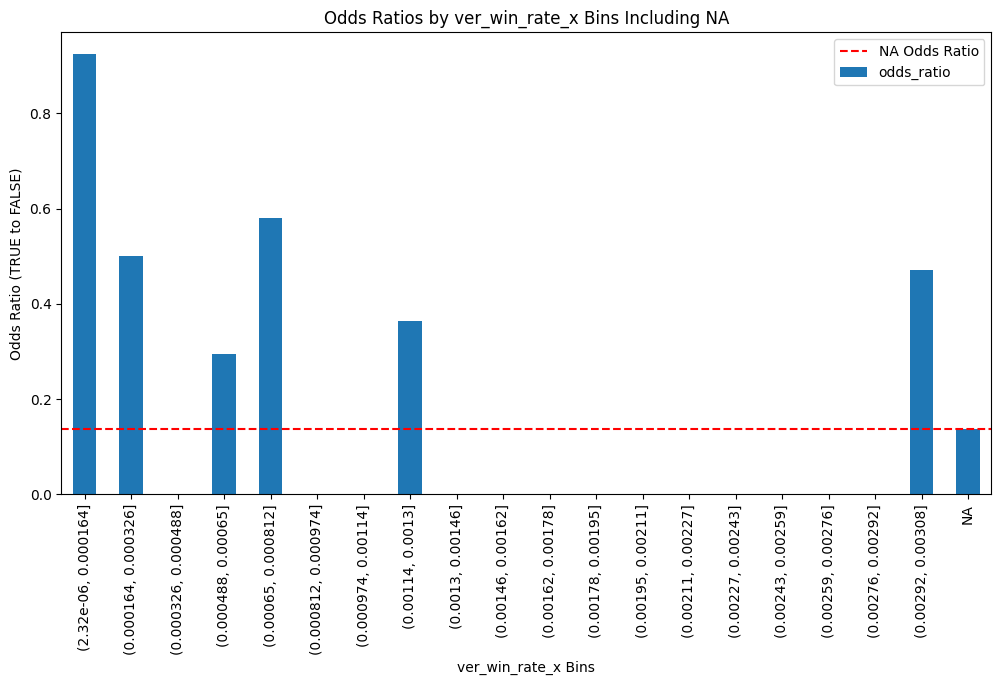

In [558]:
# Separate groups
na_group = df[df['ver_win_rate_x'].isna()]
non_na_group = df[~df['ver_win_rate_x'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'ver_win_rate_x': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['ver_win_rate_x'].min(), non_na_group['ver_win_rate_x'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_rate_x Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_rate_x Bins Including NA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### 3-8 ver_win_ratio_per_bu -> Imputed later

In [559]:
df.drop(columns='ver_win_ratio_per_bu', inplace=True, axis=1)
df.columns

Index(['id', 'bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'idit_strategic_ver', 'customer_job',
       'lead_desc_length', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_country.1',
       'customer_position', 'response_corporate', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'business_area', 'lead_owner', 'is_converted'],
      dtype='object')

### 3-9 business_area -> one hot encoding

In [560]:
print(len(df.business_area.unique()))
df.business_area.value_counts()

13


business_area
corporate / office                581
transportation                    431
retail                            318
education                         312
hotel & accommodation             177
hospital & health care            133
residential (home)                124
special purpose                    93
factory                            77
public facility                    48
government department              48
power plant / renewable energy     31
Name: count, dtype: int64

In [561]:
df['business_area'] = df['business_area'].fillna('NA')
print(len(df.business_area.unique()))
df.business_area.value_counts()

13


business_area
NA                                2898
corporate / office                 581
transportation                     431
retail                             318
education                          312
hotel & accommodation              177
hospital & health care             133
residential (home)                 124
special purpose                     93
factory                             77
public facility                     48
government department               48
power plant / renewable energy      31
Name: count, dtype: int64

## 4 NA율 50% 이하

### 4-1 customer_job -> one-hot-encoding

In [562]:
print(len(df.customer_job.unique()))
print(df.customer_job.isna().sum())

# print(df.customer_job.unique())

print(df.customer_job.value_counts())

42
1439
customer_job
engineering                         728
others                              482
education                           408
administrative                      307
information technology              231
operations                          195
purchasing                          180
consulting                          166
business development                164
sales                               162
entrepreneurship                    119
arts and design                     102
program and project management       96
marketing                            94
media and communication              48
support                              47
healthcare services                  44
finance                              42
product management                   36
accounting                           34
real estate                          26
other                                24
community and social services        22
legal                                17
human resources    

In [563]:
filtered_value_counts = value_counts[value_counts < 300]
filtered_value_counts

expected_timeline
more than a year       272
9 months ~ 1 year      264
6 months ~ 9 months    167
Name: count, dtype: int64

In [564]:
value_counts = df['customer_job'].value_counts()

# Filter for unique values with a count of more than 50
filtered_value_counts = value_counts[value_counts < 10]
another_filtered = filtered_value_counts[value_counts > 1]

# Display the filtered unique values and their counts
print(len(another_filtered))
print(another_filtered)

9
customer_job
research                            9
military and protective services    7
quality assurance                   5
radiology professional              4
curation                            3
medical imaging specialist          3
3d/vfx art                          2
healthcare                          2
film production                     2
Name: count, dtype: int64


In [565]:
# Replace the specified 'customer_job' values
df['customer_job'] = df['customer_job'].replace({
    'planner':'business development',
    'interior designer':'arts and design',
    'solution provider':'support',
    'marketing operations':'marketing',
    'marketing executive':'marketing',
    'altro':'other',
    'leader':'entrepreneurship',
    'distribuidor':'sales',
    'vice president':'entrepreneurship',
    'influencer':'marketing',
    'user':'other',
    'Ã¼zemeltetÃ©s':'operations',
    'Ã©rtÃ©kesÃ­tÃ©s':'sales',
    'following up':'other',
    'sales engineering':'sales',
    'technical director':'engineering',
    'tech':'engineering',
    'coo':'operations',
    'sales executive':'sales',
    'implement':'other',
    'it/software':'information technology',
    'field marketing':'marketing',
    'hr':'human resources',
    'producer':'media and communication',
    'procurement specialist':'purchasing',
    'product marketing':'marketing',
    'electronics & telco':'media and communication',
    'institute & academy':'education',
    'administrative assistant':'administrative',
    'purchasing agent':'purchasing',
    'radiology  professional':'radiology professional',
    'educator':'education',
    'sales manager':'sales',
    'medical imaging  specialist':'medical imaging specialist',
    'director of it':'information technology',
    'design':'arts and design',
    'higher education (college & university)':'education',
    'av tech':'operations',
    'mÃ©dia_Ã©s_kommunikÃ¡ciÃ³':'media and communication',
    'project lead':'program and project management',
    'other stores':'other',
    'healthcare professionals':'healthcare services',
    'engineering & technical executive':'engineering',
    'program_and_project_manager':'program and project management',
    'it - information technology':'information technology',
    'amministrativo':'administrative',
    'distributor':'sales',
    'mÅ±vÃ©szet_Ã©s_design':'arts and design',
    'ceo/founder':'entrepreneurship',
    'engineer':'engineering',
    'general manager':'program and project management',
    'engineering & technical':'engineering',
    'vertrieb':'sales',
    'programm-_und_projektmanagement':'program and project management',
    'executive':'entrepreneurship',
    'designer':'arts and design',
    'arquitecto/consultor':'consulting',
    'purchaser':'purchasing',
    'director':'program and project management',
    'lead':'administrative',
    'kreation_und_design':'arts and design',
    'sonstiges':'other',
    'technical':'engineering',
    'buyer':'purchasing',
    'general management':'program and project management',
    'art and design':'arts and design',
    'quality assurance':'operations',
    'curation':'arts and design',
    'project manager':'program and project management',
    'manager':'program and project management',
    'owner':'entrepreneurship',
    'finanzen':'finance',
    'gm':'program and project management',
    'medien_und_kommunikation':'media and communication',
    'decision maker':'entrepreneurship',
    'ceo':'entrepreneurship',
    'community_and_social_services':'community and social services',
    'information_technology':'information technology',
    'arts_and_design':'arts and design',
    'program_and_project_management':'program and project management',
    'otro':'other',
    'installer':'operations',
    'revendedor':'sales',
    'research & development':'research',
    'consultant':'consulting',
    'procurement':'purchasing',
    'surgery professionalâ':'surgery professional',
    'it manager':'information technology',
    'coordinator':'administrative',
    'clinic':'healthcare',
    'integrador':'operations',
    'operations manager':'operations',
    'integrator':'operations',
    'healthcare':'healthcare services',
    'it director':'information technology',
    'business_development':'business development',
    'medical solution  provider':'healthcare services',
    'media_e_comunicazione':'media and communication',
    'computing & it':'information technology',
    'advertising':'media and communication',
    'vendite':'sales',
    'egyÃ©b':'other',
    'adminisztrÃ¡ciÃ³':'administrative',
    'projektmenedzsment\tprogram and project management':'program and project management',
    'chief engineer':'engineering',
    'project coordinator':'program and project management',
    'quality_assurance':'operations',
    'healthcare_services':'healthcare services',
    'account management':'marketing',
    'it':'information technology',
    'associate/analyst':'operations',
    'reseller':'sales',
    'pm':'program and project management',
    'general contractor':'operations',
    'contractor':'operations',
    'information technologyâ':'information technology',
    'pÃ©nzÃ¼gy':'finance',
    'purchase':'purchasing',
    'sales operations':'sales',
    'pathologist':'healthcare services',
    'architect':'arts and design',
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['customer_job'].value_counts()
print(updated_counts)

#의사 결정권이 있냐 없냐에 따라서 분류 다시함.

customer_job
engineering                         728
others                              482
education                           408
administrative                      307
information technology              231
operations                          200
purchasing                          180
consulting                          166
business development                164
sales                               162
entrepreneurship                    119
arts and design                     105
program and project management       96
marketing                            94
media and communication              49
support                              47
healthcare services                  47
finance                              42
product management                   36
accounting                           34
real estate                          26
other                                24
community and social services        22
legal                                17
human resources            

In [566]:
df.customer_job.isna().sum()

1439

In [567]:
df['customer_job'] = df['customer_job'].fillna('NA')

In [568]:
# Calculate value counts for each unique value in 'customer_job'
value_counts = df['customer_job'].value_counts()

# Identify values to be replaced (value count < 3)
values_to_replace = value_counts[value_counts < 3].index.tolist()

# Replace values
df['customer_job'] = df['customer_job'].apply(lambda x: 'other' if x in values_to_replace else x)

# Verify changes by checking the new value counts
new_value_counts = df['customer_job'].value_counts()
print(len(df.customer_job.unique()))
print(new_value_counts)

30
customer_job
NA                                  1439
engineering                          728
others                               482
education                            408
administrative                       307
information technology               231
operations                           200
purchasing                           180
consulting                           166
business development                 164
sales                                162
entrepreneurship                     119
arts and design                      105
program and project management        96
marketing                             94
media and communication               49
support                               47
healthcare services                   47
finance                               42
product management                    36
accounting                            34
other                                 33
real estate                           26
community and social services         22


### 4-2 product_category -> one-hot encoding?

In [569]:
df['product_category'] = df['product_category'].fillna('NA')

In [570]:
print(len(df.product_category.unique()))
print(df.product_category.isna().sum())

print(df.product_category.unique())

print(df.product_category.value_counts())

34
0
['NA' 'hospital tv' 'led signage' 'cloud device' 'standard signage'
 'interactive signage' 'multi-split' 'video wall signage' 'vrf' 'monitor'
 'etc.' 'heating' 'ventilation' 'control' 'single-split'
 'high brightness signage' 'chiller' 'oled signage' 'special signage'
 'hotel tv' 'projector' 'medical display' 'signage care solution' 'ess'
 'laptop' 'interactive digital board' 'pro:centric' 'software solution'
 'others' 'one:quick series' 'webos' 'notebook' 'accessories' 'other']
product_category
NA                           1858
vrf                           726
multi-split                   544
interactive signage           400
led signage                   289
etc.                          202
single-split                  179
video wall signage            167
hotel tv                      134
standard signage              118
oled signage                  104
chiller                        99
interactive digital board      74
heating                        67
monitor           

In [571]:
value_counts = df['product_category'].value_counts()
filtered_value_counts = value_counts[value_counts > 10]
filtered_value_counts

product_category
NA                           1858
vrf                           726
multi-split                   544
interactive signage           400
led signage                   289
etc.                          202
single-split                  179
video wall signage            167
hotel tv                      134
standard signage              118
oled signage                  104
chiller                        99
interactive digital board      74
heating                        67
monitor                        58
high brightness signage        40
medical display                32
ventilation                    31
one:quick series               22
cloud device                   18
webos                          14
laptop                         13
control                        13
projector                      12
software solution              11
Name: count, dtype: int64

In [572]:
df['product_category'] = df['product_category'].apply(lambda x: 'signage' if 'signage' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'vrf' if 'vrf' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'inverter' if 'inverter' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'display' if 'display' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'tv' if 'tv' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'b2b' if 'cloud' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'b2b' if 'projector' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'b2b' if 'beam' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'battery' if 'solar' in x.lower() else x)
df['product_category'] = df['product_category'].apply(lambda x: 'b2b' if 'medic' in x.lower() else x)

In [573]:
value_counts = df['product_category'].value_counts()

# Filter for unique values with a count of more than 50
filtered_value_counts = value_counts[value_counts < 5]
another_filtered = filtered_value_counts[value_counts > 0]

# Display the filtered unique values and their counts
print(len(another_filtered))
print(another_filtered)

4
product_category
ess         4
others      3
other       2
notebook    1
Name: count, dtype: int64


In [574]:
# Replace the specified 'customer_job' values
df['product_category'] = df['product_category'].replace({
    'robots':'etc.',
    'washing machine,dryer':'etc.',
    '49uh / 49xf':'tv',
    'system ac,refrigerator,washing machine,dryer':'hvac',
    'ess,chiller':'hvac',
    '32 / 43 pol':'tv',
    '43uq751c0sb.bwz':'tv',
    '×\x9e×\x96×\x92×\xa0×\x99×\x9d ×\x9c×\x9e×§×\x95×\x9d ×\x9e×\x92×\x95×¨×\x99×\x9d':'etc.',
    'one quick works':'one:quick series',
    '32 pol':'tv',
    'aio | one quick':'one:quick series',
    'aircare,built-in/cooking':'hvac',
    'one quick series':'one:quick series',
    'led aio 136':'signage',
    '110 + video wall':'signage',
    'meeting & screen sharedirect view leddirect view led':'signage',
    'pendingin':'hvac',
    'lg paradise air solution':'hvac',
    '×¤××¦×× ××¨×××':'hvac',
    '×××¨':'hvac',
    '49vl5g-m':'signage',
    'single package':'hvac',
    'aircare,water care':'hvac',
    'one:quick flex':'one:quick series',
    'robot,vacuum cleaner':'robots',
    'chiller,dryer':'hvac',
    'dryer,chiller':'hvac',
    'procentric':'software solution',
    'videwall':'signage',
    'mobile,audio/video':'tv',
    'refrigerator':'hvac',
    'refrigerator,built-in/cooking':'hvac',
    'single cac':'hvac',
    '55svh7f-a':'signage',
    'tr3':'signage',
    '98uh5e':'b2b',
    'inne':'etc.',
    'chiller/enfriadoras':'hvac',
    'ems,audio/video':'tv',
    'surgical monitor':'b2b',
    'gsca046':'signage',
    'gscd100':'signage',
    '50us660h0sd.bwz':'tv',
    'cac':'hvac',
    '43 pol':'tv',
    'pantalla led outdoor':'signage',
    'scroll compressor':'hvac',
    'not specified':'etc.',
    'uh':'tv',
    'monitorindustrial_rmk':'monitor and pc',
    '55vm5j-h':'signage',
    'laec15':'signage',
    '55vm5e-a':'signage',
    'lg led bloc':'signage',
    'on or several reversible ac':'hvac',
    'systÃ¨mes de dÃ©bit Ã\xa0 rÃ©frigÃ©rant variable (drv)':'hvac',
    'multi-split,single-split':'hvac',
    'led cinema':'signage',
    'led 70m2':'signage',
    'lg magnit':'tv',
    'aircare,mobile':'hvac',
    'chiller,refrigerator':'hvac',
    'unitario':'battery',
    'refrigerator,chiller':'hvac',
    'a definir':'etc.',
    'robot,system ac':'hvac',
    '43uh5f-h.awzm':'signage',
    'Äiá»u hÃ²a trung tÃ¢m chiller':'hvac',
    'lg salang air solution for dream homes':'hvac',
    'khÃ¡c':'etc.',
    'hospitality':'tv',
    'video wall + aio':'signage',
    'gscd046':'signage',
    'other':'etc.',
    'pc,washing machine':'monitor and pc',
    'high inch 86 / 98 or 110':'tv',
    'lsca039':'signage',
    '55tc3d':'interactive digital board',
    '86uh5f':'signage',
    '43us660h (na)':'tv',
    'rac single cac':'hvac',
    'Ø¢Ø®Ø±':'etc.',
    '49vl5g-m.awzm':'signage',
    'è»é«':'etc.',
    'retaildigital':'etc.',
    'é«äº®åº¦é¡¯ç¤ºå±':'etc.',
    'one:quick':'one:quick series',
    'systÃ¨mes de dÃ©bit Ã  rÃ©frigÃ©rant variable (drv)': 'hvac',
    'laec015-gn.awz':'signage',
    'sac':'other',
    'system ac,home beauty':'hvac',
    'system air conditioner,energy storage system':'hvac',
    'essential series':'tv',
    'pro centric hotel':'tv',
    '49vl5f':'display',
    'parts':'etc.',
    'rac/cac':'hvac',
    'Ø­ÙÙÙ Ø§ÙØªØ¯ÙØ¦Ø©':'hvac',
    'refrigerator,washing machine,built-in/cooking':'hvac',
    'system ac':'hvac',
    'é«é¢é»è¦':'tv',
    'systÃ¨mes de dÃ©bit Ã  rÃ©frigÃ©rant variable (drv)':'hvac',
    'khÃ¡ch sáº¡n':'hvac',
    'split tunggal':'hvac',
    '×××××':'hvac',
    'system ac,rac':'hvac',
    'éåºé»è¦':'tv',
    'multi v':'vrf',
    'aio':'signage',
    'climatiseur rÃ©sidentiel':'hvac',
    'Äiá»u hÃ²a cá»¥c bá»':'hvac',
    'energy storage system':'solar',
    'chiller,water care':'hvac',
    '55us660h0sd.bwz':'tv',
    'transparent oled':'signage',
    'system ac,chiller,aircare':'hvac',
    'klimatyzacja multi-split':'hvac',
    '43uq751c0sf.bwz':'tv',
    'system ac,refrigerator':'hvac',
    'Äiá»u hÃ²a gia dá»¥ng':'hvac',
    'bu50nst':'tv',
    'hoteleria_us670h':'tv',
    'ac rumah':'hvac',
    'à¹à¸à¸£à¸·à¹à¸­à¸à¸à¸£à¸±à¸à¸­à¸²à¸à¸²à¸¨à¹à¸à¸·à¹à¸­à¸à¸µà¹à¸­à¸¢à¸¹à¹à¸­à¸²à¸¨à¸±à¸¢':'hvac',
    'multi split':'hvac',
    'lg home bliss air solution':'hvac',
    '55uq801c0sb.bwz':'tv',
    'ahu':'hvac',
    '50uq801c0sb.bwz':'tv',
    'computer monitors':'monitor and pc',
    'corpuh5f-':'signage',
    'medical monitors':'monitor and pc',
    'autre':'etc.',
    'à¸¯à¸¥à¸¯':'etc.',
    'system air conditioner':'hvac',
    'ç¹å¥é¡¯ç¤ºå±':'signage',
    'one quick:flex':'one:quick series',
    'ultra stretch series':'signage',
    'single split':'hvac',
    'æ¨æºé¡¯ç¤ºå±':'signage',
    '×××× ×× ×××§×× ××××¨××':'signage',
    'oled é¡¯ç¤ºå±':'signage',
    'system ac,chiller':'hvac',
    'laec015':'signage',
    'ÙØ¨Ø±Ø¯ (ØªØ´ÙÙØ±)':'hvac',
    'standard':'etc.',
    'aquecimento':'heating',
    'multi-split (plusieurs piÃ¨ces)':'hvac',
    'corpouh5f':'signage',
    'error':'etc.',
    'ØªÙÙÙÙØ§Øª':'hvac',
    'vb.':'etc.',
    'lg customer care program':'services',
    'lg one:quick':'one:quick series',
    'sales inquiry':'etc.',
    'fhd series':'tv',
    'äºåå¼é¡¯ç¤ºå±':'signage',
    'allinone_rmk':'signage',
    'system ac,aircare':'hvac',
    'ØªÙÙÙÙ ÙØªØ¨Ø±ÙØ¯':'hvac',
    'soÄutucu':'hvac',
    'leadallin':'signage',
    'chiller,aircare':'hvac',
    'Äiá»u hÃ²a trung tÃ¢m multi':'vrf',
    'led':'signage',
    'outros':'etc.',
    'lg one:quick series':'one:quick series',
    'ar condicionado residencial':'hvac',
    'residential air conditioner':'hvac',
    'idb':'interactive digital board',
    'ogrzewanie (pompy ciepÅa)':'heating',
    '43us660h0sd.awz':'tv',
    'isÄ±tma':'heating',
    'other':'etc.',
    'multi v 5 air':'vrf',
    'ur640':'signage',
    'ur640s':'signage',
    'ledallinone':'signage',
    'videowall_rmk':'signage',
    '32lq621cbsb.awz':'tv',
    '28mq780':'monitor and pc',
    'monitor & pc':'monitor and pc',
    'monitor':'monitor and pc',
    'led é¡¯ç¤ºå±':'signage',
    'multi v water 5':'vrf',
    'others':'etc.',
    'aire acondicionado residencial':'hvac',
    'residential air conditioning':'hvac',
    'a thermodynamic water heater':'heating',
    'pc':'monitor and pc',
    'laptop':'monitor and pc',
    'onequick series':'one:quick series',
    'high brightness':'signage',
    'virtual production':'signage',
    'calefacciÃ³n':'heating',
    'otros':'etc.',
    'lainnya':'etc.',
    'id':'interactive digital board',
    'solar,system ac':'solar',
    'solar,ess':'solar',
    'standalone':'tv',
    'pro:centric':'software solution',
    'education createboard':'signage',
    'heating':'hvac',
    'chiller':'hvac',
    'multi-split':'hvac',
    'single-split':'hvac',
    'rac':'hvac',
    'ventilation':'hvac',
    'video wall':'signage',
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['product_category'].value_counts()
print(updated_counts)

#call lg for domain knowledge

product_category
NA                           1858
signage                      1128
hvac                          920
vrf                           726
etc.                          207
tv                            144
interactive digital board      74
monitor and pc                 71
display                        32
b2b                            30
one:quick series               22
software solution              21
webos                          14
control                        13
accessories                     6
ess                             4
notebook                        1
Name: count, dtype: int64


## 5 NA 1000개 행 이하

In [575]:
for col in df.columns:
    if df[col].isnull().sum() > 1:
        print(col, df[col].isnull().sum()/len(df)*100)
        print(col, df[col].isnull().sum())

com_reg_ver_win_rate 66.07854297097326
com_reg_ver_win_rate 3483
inquiry_type 24.51147789793208
inquiry_type 1292
ver_win_rate_x 54.980079681274894
ver_win_rate_x 2898


In [576]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   customer_country         5271 non-null   object 
 3   business_unit            5271 non-null   object 
 4   com_reg_ver_win_rate     1788 non-null   float64
 5   customer_idx             5271 non-null   int64  
 6   customer_type            5271 non-null   object 
 7   enterprise               5271 non-null   object 
 8   historical_existing_cnt  5271 non-null   float64
 9   idit_strategic_ver       5271 non-null   float64
 10  customer_job             5271 non-null   object 
 11  lead_desc_length         5271 non-null   float64
 12  inquiry_type             3979 non-null   object 
 13  product_category         5271 non-null   object 
 14  product_subcategory     

In [577]:
# df_dropped = df.dropna(subset=['customer_country','inquiry_type'])
# df_dropped.info()

### 5-1 customer_country.1 -> target encoding

In [578]:
def extract_country(value, response_corporate):
    # Mapping for response_corporate to country names
    corporate_to_country = {
        'LGEUS': 'United States',
        'LGECB': 'Colombia',
        'LGEDG': 'Germany',
        'LGEIL': 'India',
        'LGESP': 'Brazil',
        'LGEPH': 'Philippines',
        'LGEIN': 'Indonesia',
        'LGEEG': 'Egypt',
        'LGEUK': 'United Kingdom',
        'LGETK': 'Turkey',
        'LGEMS': 'Mexico',
        'LGEFS': 'France',
        'LGEES': 'Spain'
    }
    
    # Function to determine if replacement is needed based on the content of the value
    def needs_replacement(val):
        if '@' in val or any(char.isdigit() for char in val):
            return True
        words = val.split()
        return len(words) > 2
    
    # Initial check for NaN or non-string types
    if pd.isna(value) or not isinstance(value, str):
        return 'NA'
    
    # Check for email formats or if replacement is needed based on the content
    if '@' in value or needs_replacement(value):
        return 'Egypt' if '@' in value else corporate_to_country.get(response_corporate, 'NA')
    
    # Modified process to handle '//'
    country = 'NA'
    if '//' in value:
        # Split the value on '//' and take the last part
        parts = value.split('//')
        country = parts[-1].strip().title() if parts[-1].strip() else parts[-2].strip().title()
    elif '/' in value:
        parts = value.strip('/').split('/')
        country = parts[-1].strip().title()
    
    # Final check for replacement based on processed country
    if needs_replacement(country):
        return corporate_to_country.get(response_corporate, 'NA')
    
    if country == ' ':
        return corporate_to_country.get(response_corporate, 'NA')
    
    return country if country != 'NA' else value.strip().title()


# Re-apply the function with the enhanced logic
df['customer_country.1_normalized'] = df.apply(lambda x: extract_country(x['customer_country.1'], x['response_corporate']), axis=1)

# Verify the transformation
print(df[['customer_country.1', 'response_corporate', 'customer_country.1_normalized']].head())

                                  customer_country.1 response_corporate  \
0                                        /  / Brazil              LGESP   
1  400 N State Of Franklin Rd  Cloud IT / Johnson...              LGEUS   
2                                         /  / U.A.E              LGEGF   
3                         / Madison  / United States              LGEUS   
4                               / Sao Paulo / Brazil              LGESP   

  customer_country.1_normalized  
0                        Brazil  
1                 United States  
2                            NA  
3                 United States  
4                        Brazil  


In [579]:
df['customer_country.1'] = df['customer_country.1_normalized']
df.drop(columns=['customer_country.1_normalized'], inplace=True)
len(df.columns)

25

In [580]:
# # Remove leading and trailing spaces from the 'customer_country_normalized' column
# df['customer_country_normalized'] = df['customer_country_normalized'].str.strip()

# # Display the first few rows to verify that the spaces have been removed
# print(df[['customer_country.1', 'customer_country_normalized']].head())

In [581]:
df['customer_country.1'].fillna('NA', inplace=True)

#count NA values in customer_country.1
df['customer_country.1'].isnull().sum()
df['customer_country.1'].value_counts()

customer_country.1
NA                1204
Brazil            1045
United States      981
India              906
Philippines        289
Mexico             181
Colombia           125
Egypt               96
Indonesia           95
Germany             73
Turkey              48
United Kingdom      42
                    32
U.A.E               26
Spain               17
France              16
Chile               12
Australia           11
Peru                11
Argentina           10
Vietnam              6
Hong Kong            5
Poland               4
Saudi Arabia         4
Tã¼Rkiye             3
Malaysia             2
Singapore            2
Ecuador              2
Panama               2
Canada               2
Curaã§Ao             1
Afghanistan          1
Senegal              1
Kenya                1
Lithuania            1
Bahrain              1
Costa Rica           1
Oman                 1
Rajkot               1
Algeria              1
Nigeria              1
South Africa         1
Malta          

In [582]:
value_counts = df['customer_country.1'].value_counts()

# Filter for unique values with a count of more than 50
filtered_value_counts = value_counts[value_counts < 1000]
another_filtered = filtered_value_counts[value_counts > 100]

# Display the filtered unique values and their counts
print(df['customer_country.1'].unique())
print(len(another_filtered))
print(another_filtered)

['Brazil' 'United States' 'NA' 'Germany' 'Egypt' 'France' '' 'Indonesia'
 'India' 'Turkey' 'Philippines' 'Colombia' 'Mexico' 'Hong Kong' 'U.A.E'
 'United Kingdom' 'Singapore' 'Israel' 'Vietnam' 'Peru' 'Argentina'
 'Poland' 'Spain' 'Australia' 'Algeria' 'Chile' 'Ecuador' 'Saudi Arabia'
 'Tã¼Rkiye' 'Puerto Rico' 'Italy' 'El Salvador' 'Thailand' 'Malaysia'
 'Malta' 'Canada' 'Panama' 'South Africa' 'Nigeria' 'Curaã§Ao' 'Rajkot'
 'Afghanistan' 'Senegal' 'Lithuania' 'Bahrain' 'Costa Rica' 'Kenya' 'Oman'
 'Iraq']
5
customer_country.1
United States    981
India            906
Philippines      289
Mexico           181
Colombia         125
Name: count, dtype: int64


In [583]:
df['customer_country.1'] = df['customer_country.1'].replace({
    "Cote D'Ivoire": 'Ivory Coast',
    'Uae Dubai':'U.A.E',
    '':'NA',
    'Na':'NA',
    'Tã¼Rkiye':'Turkey',
    'Ä¸Æµ·':'NA',
    'Austin':'United States',
    'Bhilai':'India',
    'Lucknow':'India',
    'Bemetara':'India',
    'Buldana':'India',
    'A': 'NA',
    'Dasmarinas City':'Philippines',
    'Mandaluyong City':'Philippines',
    'Angeles City':'Philippines',
    'Angeles':'Philippines',
    'Bataan':'Philippines',
    'San Antonio':'United States',
    'Gurgaon':'India',
    'Makkah':'Saudi Arabia',
    'Mauritania':'Mauritius',
    'Beloit':'United States',
    'Orange':'United States',
    'Netherlands Antilles':'Netherlands',
    'Paranaque':'Philippines',
    'Cincinnati':'United States',
    'Pasig':'Philippines',
    'Taytay':'Philippines',
    'Sacramento':'United States',
    'Riyadh':'Saudi Arabia',
    'Pasig City':'Philippines',
    'Hosapete':'India',
    'Vandenberg Sfb':'United States',
    'Bridgeport':'United States',
    'New York':'United States',
    'Leesburg':'United States',
    'St Maarten':'Netherlands',
    'Rizal':'Philippines',
    'Paraã±Aque':'Philippines',
    'San Juan':'Philippines',
    'Bhilwara':'India',
    'Dourados':'Brazil',
    'Bucaramanga':'Colombia',
    'Cartagena':'Colombia',
    'Ahemdabad/':'India',
    'Udupi':'India',
    'Jacksonville':'United States',
    'Fort Bragg':'United States',
    'Durham':'United States',   
    'Tucson':'United States',
    'Amman':'Jordan',
    'Agost, Alicante':'Spain',
    'Madrid':'Spain',
    'Cuiabã¡':'Brazil',
    'Colombia  Cartagena':'Colombia',
    'Swaziland':'Eswatini',
    'Caceres':'Spain',
    'Test':'NA',
    'Noida':'India',
    'Qc':'Philippines',
    'Guwahati':'India',
    'Ajmer':'India',
    'Satana':'India',
    'Mysore':'India',
    'Muzaffarpur':'India',
    'Washington Dc':'United States',
    'Firenze, Italy':'Italy',
    'Joã£O Pessoa':'Brazil',
    'Ahemdabad':'India',
    'Kanpur':'India',
    'Sangli':'India',
    'Sã£O Paulo':'Brazil',
    'Barranquilla':'Colombia',
    'Recife':'Brazil',
    'Omaha':'United States',
    'Camarines Sur':'Philippines',
    'Dallas':'United States',
    'Jodhpur City':'India',
    'Surat':'India',
    'Ammanabrolu':'India',
    'Belo Horizonte':'Brazil',
    'Caloocan City':'Philippines',
    'Bloch':'Germany',
    'Bangalore':'India',
    'Quezon City':'Philippines',
    'Makati':'Philippines',
    'Makati City':'Philippines',
    'Antigua':'Antigua and Barbuda',
    'Bermuda':'United Kingdom',
    'Mumbai':'India',
    'Providencaies':'United Kingdom',
    'Bulacan':'Philippines',
    'Valencia':'Spain',
    'Ha Noi':'Vietnam',
    'Jacksonville Florida':'United States',
    'Newark':'United States',
    'Telangana':'India',
    'Cebu':'Philippines',
    'Delhi':'India',
    'Bangalore/':'India',
    'Los Angeles':'United States',
    'Gujarat':'India',
    'Detroit':'United States',
    'Cavite':'Philippines',
    'Indore':'India',
    'Mandaluyong':'Philippines',
    'Hyderabad':'India',
    'Mathura/':'India',
    'Odisha':'India',
    'Greenville':'United States',
    'Pune':'India',
    'Namakkal':'India',
    'Jalgaon':'India',
    'Bathinda':'India',
    'Dhanbad':'India',
    'Manaus':'Brazil',
    'Bari, Italy':'Italy',
    'Sao Paulo':'Brazil',
    'Hemlock':'United States',
    'Tokyo':'Japan',
    'Raipur':'India',
    'Davangere':'India',
    'Aparecida':'Brazil',
    'Dubreuilville':'Canada',
    'India/Lucknow':'India',
    'Elche, Alicante':'Spain',
    'Phoenix':'United States',
    'Thai Binh':'Vietnam',
    'Maharashtra/':'India',
    'Lake':'United States',
})

updated_counts = df['customer_country.1'].value_counts()
print(updated_counts)

customer_country.1
NA                1236
Brazil            1045
United States      981
India              906
Philippines        289
Mexico             181
Colombia           125
Egypt               96
Indonesia           95
Germany             73
Turkey              51
United Kingdom      42
U.A.E               26
Spain               17
France              16
Chile               12
Australia           11
Peru                11
Argentina           10
Vietnam              6
Hong Kong            5
Poland               4
Saudi Arabia         4
Malaysia             2
Singapore            2
Ecuador              2
Panama               2
Canada               2
Curaã§Ao             1
Afghanistan          1
Senegal              1
Kenya                1
Lithuania            1
Bahrain              1
Costa Rica           1
Oman                 1
Rajkot               1
Algeria              1
Nigeria              1
South Africa         1
Malta                1
Thailand             1
El Salvador    

### 5-2 customer_country -> dropped

In [584]:
df.drop(columns=['customer_country'], inplace=True)

### 5-3 inquiry_type -> target encoding

In [585]:
print(len(df['inquiry_type'].unique()))
df['inquiry_type'] = df['inquiry_type'].fillna('NA')

16


In [586]:
# Replace the specified 'inquiry_type' values
df['inquiry_type'] = df['inquiry_type'].replace({
    'Quotation or Purchase Consultation': 'Quotation or purchase consultation',  # merge into 'less than 3 months'
    'quotation_or_purchase_consultation': 'Quotation or purchase consultation',  # merge into 'being followed up.'
    'quotation_':'Quotation or purchase consultation',
    'Quotation or Purchase consultation':'Quotation or purchase consultation',
    'Purchase or Quotation':'Quotation or purchase consultation',
    'Purchase' : 'Quotation or purchase consultation',
    'Usage or Technical Consultation':'Usage or technical consultation',
    'Technical Consultation':'Usage or technical consultation',
    'technical':'Usage or technical consultation',
    'usage or technical consultation' : 'Usage or technical consultation',
    'usage_or_technical_consultation':'Usage or technical consultation',
    'Technical Support':'Usage or technical consultation',
    'technical_consultation':'Usage or technical consultation',
    'Sales Inquiry':'Sales inquiry',
    'sales':'Sales inquiry',
    'estoy buscando para Ecuador este producto LG MAGNIT micro LED, para un cliente de 138 pulgadas, con enviÃ\x83Â³ marÃ\x83Â\xadtimo.':'Product inquiry',
    'Hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en Guayaquil -Ecuador.': 'Product inquiry',
    'window facing product':'Product inquiry',
    'Vui lÃ\x83Â²ng bÃ\x83Â¡o giÃ\x83Â¡ giÃ\x83Âºp mÃ\x83Â¬nh sÃ¡ÂºÂ£n phÃ¡ÂºÂ©m Ã\x84Â\x91o thÃ\x83Â¢n nhiÃ¡Â»Â\x87t Xin cÃ¡ÂºÂ£m Ã\x86Â¡n':'Product inquiry',
    'Hotel TV products':'Product inquiry',
    'Probeam precio':'Product inquiry',
    'Pantallas Interactivas para Clinicas':'Product inquiry',
    'Solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la soluciÃ\x83Â³nÃ\x82Â\xa0One Quick:Ã\x82Â\xa0':'Product inquiry',
    'IntÃ\x83Â©grateur historique du George V':'Product inquiry',
    'IDB':'Product inquiry',
    'for school':'Product inquiry',
    'LED Signage':'Product inquiry',
    'Standalone':'Product inquiry',
    'Video Wall':'Product inquiry',
    'Toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung':'Product inquiry',
    'tÃ\x83Â´i cÃ¡ÂºÂ§n tham khÃ¡ÂºÂ£o giÃ\x83Â¡ vÃ\x83Â\xa0 giÃ¡ÂºÂ£i phÃ\x83Â¡p tÃ¡Â»Â« LG':'Product inquiry',
    'Preciso de um monitor mÃ\x83Â©dico para radiografia convencional e tomogrtafia.': 'Product inquiry',
    'VRF':'Product inquiry',
    'Evento_SdelEstero':'Product inquiry',
    'Product Information':'Product inquiry',
    'AIO':'Product inquiry',
    'Hospital TV':'Product inquiry',
    'TV interactive':'Product inquiry',
    'Display Textbook and photos':'Product inquiry',
    'Others':'Other',
    'others':'Other',
    'other':'Other',
    'ETC.': 'Other',
    'Etc.': 'Other',
    'other_':'Other',
    'High inch 86 / 98 or 110':'Product inquiry',
    'EDUCATIONAL EQUIPMENTS':'Product inquiry',
    'teach':'Product inquiry',
    'Not specified':'Other',
    'One Quick:Flex':'Product inquiry',
    'Digital platform':'Product inquiry',
    'display product':'Product inquiry',
    'Request for technical consulting':'Usage or technical consultation',
    'Request for quotation or purchase':'Quotation or purchase consultation',
    'Request a Demo':'Usage or technical consultation',
    'Request for Distributorship':'Sales inquiry',
    'Request for Partnership':'Sales inquiry',
    'Event Inquiry':'Sales inquiry',
    'Media Inquiry':'Product inquiry',
    'Needs':'Other',
    '(Select ID_Needs)':'Other',
    'OEM/ODM Request':'Sales inquiry',
    'i want to know the details about it':'Other',
    'first Info and pricing':'Product inquiry'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['inquiry_type'].value_counts()
print(len(updated_counts))
print(updated_counts)

9
inquiry_type
Quotation or purchase consultation    3465
NA                                    1292
Usage or technical consultation        196
Other                                  122
Product inquiry                         70
Sales inquiry                           67
Services                                34
Trainings                               21
Customer Suggestions                     4
Name: count, dtype: int64


In [587]:
len(df.columns)

24

## print pre-processed 

In [ ]:
df.to_csv('preprocessed_submission_final.csv', index=False)